# Classification without labels (CWoLa)

This week we will use the CWoLa method to find anomalous di-jet events in LHC data.

Background:
- Classification without labels is an semi-supervised classification technique, where we define two data samples, and assume that one contains much more of the signal class than the other
- In our case we'll use the LHC Olympics dataset, where each event consists of two jets
- Instead of working with low-level constituent-level information we will use high-level observables:
    - jet masses - $m_{j_1}$ and $m_{j_2}$
    - N-subjettiness - $\left(\tau_{21}\right)_{1}$ and $\left(\tau_{21}\right)_{2}$
    - $\tau_{21}$ is an observable which measures how two-prong a jet is
    - the other subscripts refer to the two jets in the event, with the highest $p_T$ jet coming first
- To define the two data samples we use in the CWoLa method we will use the invariant mass observable, this is similar to what is done in a 'bump-hunt' search at the LHC
- You will see from the plots below that the signal events have invariant masses clustered around $3.5$ TeV, so we choose:
    - Signal-region: jets in $3$ TeV $\leq m_{JJ} \leq$ $4$ TeV
    - Sideband-region: jets with $m_{JJ}<3$ TeV or $m_{JJ}>4$ TeV
- To implement the CWoLa method we then build a binary classifier to classify between the events in the two regions, because there are more signal events in the signal enriched region than in the sideband-region the classifier should be able to learn to separate signal and background
- **please read up on this in the lecture notes**
- In the data sample provided, there are 100k signal events and 1M background events, so it should be easy to find the signal
- However, this gets more difficult as the number of signal events is decreased

Interesting papers:
- Classification without labels: Learning from mixed samples in high energy physics
    - Eric M. Metodiev, Benjamin Nachman, Jesse Thaler
    - https://arxiv.org/abs/1708.02949
- Extending the Bump Hunt with Machine Learning
    - Jack H Collins, Kiel Howe, Benjamin Nachman
    - https://arxiv.org/abs/1902.02634
- Dijet resonance search with weak supervision using $s=\sqrt{13}$ TeV pp collisions in the ATLAS detector
    - ATLAS collaboration
    - https://arxiv.org/abs/2005.02983

Outline:
- Imports and plotting set-up
- Study the data
- Select a signal window
- Building the dataset
    - Preprocessing
    - Dataloaders
- Building the semi-supervised CWoLa classifier
- Optimise the classifier
    - if you need to, you can reduce the total number of events so that this runs on a laptop
- Study the results
- Reduce the number of signal events a re-train the classifier
    - when does the performance break down?
- What else might limit the performance?  Correlations?
- Study the optimal case of no correlations in the data
    - 'signal-region data' = 100k background events and 10k signal events, both from the signal region
    - 'sideband-region data' = 100k different background events, also from the signal region

Some tips:
- read up on the CWoLa method in your lecture notes and understand the different steps taken
- and again, a lot of the code you need is in the previous tutorial notebooks!

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

Using the LHC Olympics dataset.

In [3]:
dat = np.load( "tutorial-10-data/lhco-dat.npy" )
lbs = np.load( "tutorial-10-data/lhco-lbs.npy" )
msq = np.load( "tutorial-10-data/lhco-msq.npy" )

Now the train/val/test split:

In [4]:
trn_dat = dat[0:900000]
trn_lbs = lbs[0:900000]
trn_msq = msq[0:900000]

val_dat = dat[900000:1000000]
val_lbs = lbs[900000:1000000]
val_msq = msq[900000:1000000]

tst_dat = dat[1000000:11000000]
tst_lbs = lbs[1000000:11000000]
tst_msq = msq[1000000:11000000]

## Study the data

Let's plot the invariant mass of the signal and background events separately.

We can clearly see the mass peak for the signal events at $3.5$ TeV, while the mass distribution for the background events falls exponentially.

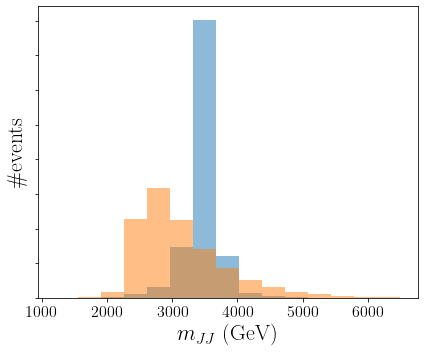

In [5]:
fig, axs = plt.subplots( figsize=(6,5) )

axs.hist( msq[ np.where(lbs==1.0) ], alpha=0.5, density=True, bins=15, range=(1200,6500) )
axs.hist( msq[ np.where(lbs==0.0) ], alpha=0.5, density=True, bins=15, range=(1200,6500) )

axs.set_xlabel( "$m_{JJ}$ (GeV)", fontproperties=axislabelfont )
axs.set_ylabel( "\#events", fontproperties=axislabelfont )

yticks = [  ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

fig.tight_layout()
fig.show()

We can also visualise the 4 features, 2 for each jet in the events.

Here we see that these 4 observables are particularly good at separating the signal and background events!

This is because the signal events come from a process $pp\rightarrow A \rightarrow B~C$, where 
- $m_A=3.5$ TeV
- $m_B=0.4$ TeV
- $m_C=0.1$ TeV

Particles $B$ and $C$ then decay to two quarks each, giving these jets a boosted two-prong topology which we can see from the skewed N-subjettiness distributions.

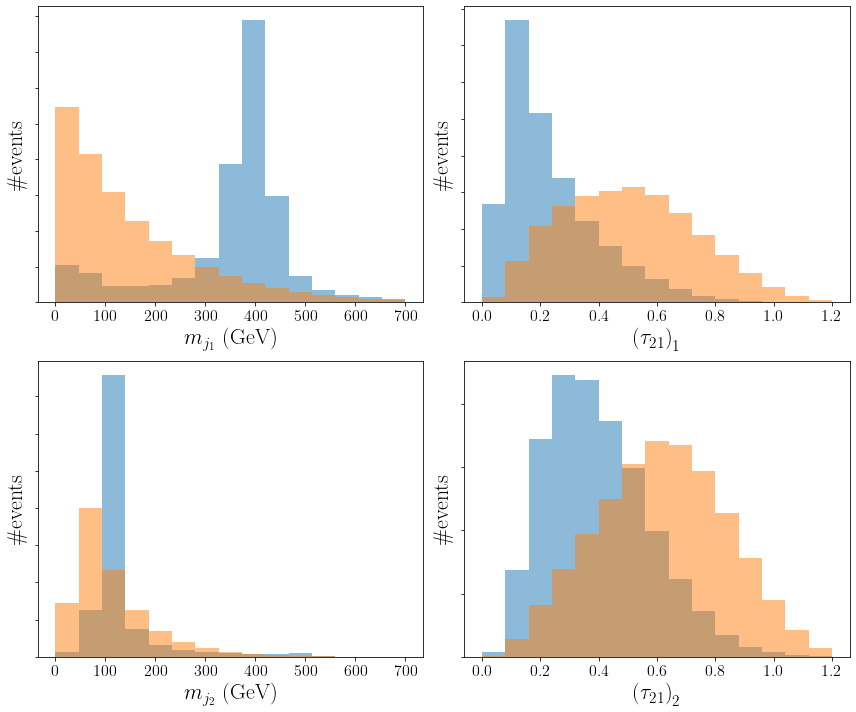

In [6]:
fig, axs = plt.subplots( 2, 2, figsize=(12,10) )

axs[0,0].hist( dat[:,0][ np.where(lbs==1.0) ], alpha=0.5, density=True, bins=15, range=(0,700) )
axs[0,0].hist( dat[:,0][ np.where(lbs==0.0) ], alpha=0.5, density=True, bins=15, range=(0,700) )
axs[0,0].set_xlabel( "$m_{j_1}$ (GeV)", fontproperties=axislabelfont )
axs[0,0].set_ylabel( "\#events", fontproperties=axislabelfont )
xticks = [ int(x) for x in axs[0,0].get_xticks() ]
axs[0,0].set_xticklabels( xticks, fontproperties=tickfont )
yticks = [  ]
axs[0,0].set_yticklabels( yticks, fontproperties=tickfont )

axs[0,1].hist( dat[:,1][ np.where(lbs==1.0) ], alpha=0.5, density=True, bins=15, range=(0,1.2) )
axs[0,1].hist( dat[:,1][ np.where(lbs==0.0) ], alpha=0.5, density=True, bins=15, range=(0,1.2) )
axs[0,1].set_xlabel( "$\\left(\\tau_{21}\\right)_{1}$", fontproperties=axislabelfont )
axs[0,1].set_ylabel( "\#events", fontproperties=axislabelfont )
xticks = [ round(x,2) for x in axs[0,1].get_xticks() ]
axs[0,1].set_xticklabels( xticks, fontproperties=tickfont )
yticks = [  ]
axs[0,1].set_yticklabels( yticks, fontproperties=tickfont )

axs[1,0].hist( dat[:,2][ np.where(lbs==1.0) ], alpha=0.5, density=True, bins=15, range=(0,700) )
axs[1,0].hist( dat[:,2][ np.where(lbs==0.0) ], alpha=0.5, density=True, bins=15, range=(0,700) )
axs[1,0].set_xlabel( "$m_{j_2}$ (GeV)", fontproperties=axislabelfont )
axs[1,0].set_ylabel( "\#events", fontproperties=axislabelfont )
xticks = [ int(x) for x in axs[1,0].get_xticks() ]
axs[1,0].set_xticklabels( xticks, fontproperties=tickfont )
yticks = [  ]
axs[1,0].set_yticklabels( yticks, fontproperties=tickfont )

axs[1,1].hist( dat[:,3][ np.where(lbs==1.0) ], alpha=0.5, density=True, bins=15, range=(0,1.2) )
axs[1,1].hist( dat[:,3][ np.where(lbs==0.0) ], alpha=0.5, density=True, bins=15, range=(0,1.2) )
axs[1,1].set_xlabel( "$\\left(\\tau_{21}\\right)_{2}$", fontproperties=axislabelfont )
axs[1,1].set_ylabel( "\#events", fontproperties=axislabelfont )
xticks = [ round(x,2) for x in axs[1,1].get_xticks() ]
axs[1,1].set_xticklabels( xticks, fontproperties=tickfont )
yticks = [  ]
axs[1,1].set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()
fig.show()

## Select a signal window

The CWoLa method requires us to train a binary classifier where the labels identify which bin the event came from, so here we split the data into the signal and sideband bins to label them.

In [7]:
msq_window = [3000,4000]

In [8]:
trn_dat_sw = trn_dat[ [ ( m > msq_window[0] and m < msq_window[1] ) for m in trn_msq ] ]
trn_lbs_sw = trn_lbs[ [ ( m > msq_window[0] and m < msq_window[1] ) for m in trn_msq ] ]
trn_dat_sb = trn_dat[ [ ( m < msq_window[0] or m > msq_window[1] ) for m in trn_msq ] ]
trn_lbs_sb = trn_lbs[ [ ( m < msq_window[0] or m > msq_window[1] ) for m in trn_msq ] ]

val_dat_sw = val_dat[ [ ( m > msq_window[0] and m < msq_window[1] ) for m in val_msq ] ]
val_lbs_sw = val_lbs[ [ ( m > msq_window[0] and m < msq_window[1] ) for m in val_msq ] ]
val_dat_sb = val_dat[ [ ( m < msq_window[0] or m > msq_window[1] ) for m in val_msq ] ]
val_lbs_sb = val_lbs[ [ ( m < msq_window[0] or m > msq_window[1] ) for m in val_msq ] ]

tst_dat_sw = tst_dat[ [ ( m > msq_window[0] and m < msq_window[1] ) for m in tst_msq ] ]
tst_lbs_sw = tst_lbs[ [ ( m > msq_window[0] and m < msq_window[1] ) for m in tst_msq ] ]
tst_dat_sb = tst_dat[ [ ( m < msq_window[0] or m > msq_window[1] ) for m in tst_msq ] ]
tst_lbs_sb = tst_lbs[ [ ( m < msq_window[0] or m > msq_window[1] ) for m in tst_msq ] ]

We check the shapes and the sums, the sums tell us how many signal events there is in the bin since they are labelled with a $1.0$.

In [9]:
trn_dat_sw.shape, trn_lbs_sw.shape, trn_dat_sb.shape, trn_lbs_sb.shape, trn_lbs_sw.sum(), trn_lbs_sb.sum()

((380294, 4), (380294,), (519706, 4), (519706,), 76608, 5117)

In [10]:
val_dat_sw.shape, val_lbs_sw.shape, val_dat_sb.shape, val_lbs_sb.shape, val_lbs_sw.sum(), val_lbs_sb.sum()

((42375, 4), (42375,), (57625, 4), (57625,), 8613, 578)

In [11]:
tst_dat_sw.shape, tst_lbs_sw.shape, tst_dat_sb.shape, tst_lbs_sb.shape, tst_lbs_sw.sum(), tst_lbs_sb.sum()

((42020, 4), (42020,), (57980, 4), (57980,), 8481, 603)

# Datasets and dataloaders

Before constructing the dataloaders we need to put the data together again and define the bin labels that we will use in training.

In [12]:
X_train = np.concatenate( (trn_dat_sw,trn_dat_sb), axis=0 )
y_train = np.concatenate( (trn_lbs_sw,trn_lbs_sb), axis=0 )
b_train = np.concatenate( ( np.ones( trn_lbs_sw.shape[0] ), np.zeros( trn_lbs_sb.shape[0] ) ), axis=0 )

X_val = np.concatenate( (val_dat_sw,val_dat_sb), axis=0 )
y_val = np.concatenate( (val_lbs_sw,val_lbs_sb), axis=0 )
b_val = np.concatenate( ( np.ones( val_lbs_sw.shape[0] ), np.zeros( val_lbs_sb.shape[0] ) ), axis=0 )

X_test = np.concatenate( (tst_dat_sw,tst_dat_sb), axis=0 )
y_test = np.concatenate( (tst_lbs_sw,tst_lbs_sb), axis=0 )
b_test = np.concatenate( ( np.ones( tst_lbs_sw.shape[0] ), np.zeros( tst_lbs_sb.shape[0] ) ), axis=0 )

In [13]:
X_train.shape, y_train.shape, b_train.shape

((900000, 4), (900000,), (900000,))

In [14]:
X_val.shape, y_val.shape, b_val.shape

((100000, 4), (100000,), (100000,))

In [15]:
X_test.shape, y_test.shape, b_test.shape

((100000, 4), (100000,), (100000,))

We define the CWoLa dataset such that get_item returns the data, the true sig/bkg labels, and the bin label.

In [16]:
class cwola_data( Dataset ):
    
    def __init__( self, data, labels,  bins ):
        self.data = data
        self.labels = labels
        self.bins = bins

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.bins[idx]

In [17]:
X_train_p = torch.Tensor( X_train )
y_train_p = torch.Tensor( y_train ).unsqueeze(-1)
b_train_p = torch.Tensor( b_train ).unsqueeze(-1)

X_val_p = torch.Tensor( X_val )
y_val_p = torch.Tensor( y_val ).unsqueeze(-1)
b_val_p = torch.Tensor( b_val ).unsqueeze(-1)

X_test_p = torch.Tensor( X_test )
y_test_p = torch.Tensor( y_test ).unsqueeze(-1)
b_test_p = torch.Tensor( b_test ).unsqueeze(-1)

In [18]:
trn_dataset = cwola_data( X_train_p, y_train_p, b_train_p )
val_dataset = cwola_data( X_val_p, y_val_p, b_val_p )
tst_dataset = cwola_data( X_test_p, y_test_p, b_test_p )

In [19]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

## Build the CWoLa classifier

The CWoLa classifier is just a regular binary classifier, so there's not much work to do here.  We define the classifier below.

In [20]:
class cwolaNet( torch.nn.Module ):
    
    def __init__( self, data_dim, hiddenlayer_size ):
        super( cwolaNet, self ).__init__()
                
        self.layer1 = nn.Linear( data_dim, hiddenlayer_size )
        self.relu_1 = nn.ReLU()
        self.layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.relu_2 = nn.ReLU()
        self.layer3 = nn.Linear( hiddenlayer_size, 1 )
        
    def forward( self, batch ):
        
        x = self.layer1( batch )
        x = self.relu_1( x )
        x = self.layer2( x )
        x = self.relu_2( x )
        x = self.layer3( x )
        
        return torch.sigmoid( x )

## Optimising the classifier

The difference with CWoLa and a regular supervised classifier is in how we train it, as with CWoLa we train the classifier on the bin labels.

First, we set the device.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Then the binary cross-entropy loss.

In [22]:
loss_fn = nn.BCELoss()

When defining the training loop and the functions to evaluate the training and validation losses we need to be careful that we pass the bin label to the classifier.

In [23]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, (X, y, b) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn( pred, b )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [24]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y, b in dataloader:
            pred = model( X )
            vl += loss_fn( pred, b ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y, b in dataloader:
            pred = model( X )
            tl += loss_fn( pred, b ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

Now we can optimise the network in the same way we would optimise a supervised classifier.

Since we have so many events here we won't train the network for too long.

In [66]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 15

# re-initialise the model and the optimizer
model = cwolaNet( 4, 64 ).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
cwolaNet(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (relu_1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): ReLU()
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 2.792623  [    0/900000]
current batch loss: 0.712343  [ 6400/900000]
current batch loss: 0.763443  [12800/900000]
current batch loss: 0.776673  [19200/900000]
current batch loss: 0.760521  [25600/900000]
current batch loss: 0.669799  [32000/900000]
current batch loss: 0.687167  [38400/900000]
current batch loss: 0.648401  [44800/900000]
current batch loss: 0.637791  [51200/900000]
current batch loss: 0.640539  [57600/900000]
current batch loss: 0.650114  [64000/900000]
current batch loss: 0.722756  [70400/900000]
cur

current batch loss: 0.693525  [134400/900000]
current batch loss: 0.617278  [140800/900000]
current batch loss: 0.612064  [147200/900000]
current batch loss: 0.648674  [153600/900000]
current batch loss: 0.678957  [160000/900000]
current batch loss: 0.671588  [166400/900000]
current batch loss: 0.591623  [172800/900000]
current batch loss: 0.621382  [179200/900000]
current batch loss: 0.637007  [185600/900000]
current batch loss: 0.669996  [192000/900000]
current batch loss: 0.665981  [198400/900000]
current batch loss: 0.648951  [204800/900000]
current batch loss: 0.548946  [211200/900000]
current batch loss: 0.601353  [217600/900000]
current batch loss: 0.629203  [224000/900000]
current batch loss: 0.634871  [230400/900000]
current batch loss: 0.642401  [236800/900000]
current batch loss: 0.630574  [243200/900000]
current batch loss: 0.588158  [249600/900000]
current batch loss: 0.636131  [256000/900000]
current batch loss: 0.727524  [262400/900000]
current batch loss: 0.655501  [268

current batch loss: 0.610461  [332800/900000]
current batch loss: 0.598198  [339200/900000]
current batch loss: 0.644099  [345600/900000]
current batch loss: 0.629855  [352000/900000]
current batch loss: 0.632144  [358400/900000]
current batch loss: 0.669864  [364800/900000]
current batch loss: 0.646260  [371200/900000]
current batch loss: 0.541356  [377600/900000]
current batch loss: 0.658320  [384000/900000]
current batch loss: 0.554158  [390400/900000]
current batch loss: 0.606635  [396800/900000]
current batch loss: 0.664699  [403200/900000]
current batch loss: 0.633700  [409600/900000]
current batch loss: 0.667818  [416000/900000]
current batch loss: 0.602163  [422400/900000]
current batch loss: 0.649641  [428800/900000]
current batch loss: 0.702940  [435200/900000]
current batch loss: 0.628979  [441600/900000]
current batch loss: 0.649248  [448000/900000]
current batch loss: 0.639356  [454400/900000]
current batch loss: 0.642738  [460800/900000]
current batch loss: 0.619441  [467

current batch loss: 0.684365  [531200/900000]
current batch loss: 0.633027  [537600/900000]
current batch loss: 0.654466  [544000/900000]
current batch loss: 0.667071  [550400/900000]
current batch loss: 0.595218  [556800/900000]
current batch loss: 0.621576  [563200/900000]
current batch loss: 0.648997  [569600/900000]
current batch loss: 0.680851  [576000/900000]
current batch loss: 0.622850  [582400/900000]
current batch loss: 0.581645  [588800/900000]
current batch loss: 0.655746  [595200/900000]
current batch loss: 0.661219  [601600/900000]
current batch loss: 0.614719  [608000/900000]
current batch loss: 0.659513  [614400/900000]
current batch loss: 0.621244  [620800/900000]
current batch loss: 0.646232  [627200/900000]
current batch loss: 0.666188  [633600/900000]
current batch loss: 0.667162  [640000/900000]
current batch loss: 0.633241  [646400/900000]
current batch loss: 0.605777  [652800/900000]
current batch loss: 0.683928  [659200/900000]
current batch loss: 0.615575  [665

current batch loss: 0.677195  [736000/900000]
current batch loss: 0.738038  [742400/900000]
current batch loss: 0.587983  [748800/900000]
current batch loss: 0.615730  [755200/900000]
current batch loss: 0.651910  [761600/900000]
current batch loss: 0.599650  [768000/900000]
current batch loss: 0.615377  [774400/900000]
current batch loss: 0.597821  [780800/900000]
current batch loss: 0.704545  [787200/900000]
current batch loss: 0.624061  [793600/900000]
current batch loss: 0.701296  [800000/900000]
current batch loss: 0.567436  [806400/900000]
current batch loss: 0.670076  [812800/900000]
current batch loss: 0.619137  [819200/900000]
current batch loss: 0.666178  [825600/900000]
current batch loss: 0.632530  [832000/900000]
current batch loss: 0.621620  [838400/900000]
current batch loss: 0.653826  [844800/900000]
current batch loss: 0.648385  [851200/900000]
current batch loss: 0.574538  [857600/900000]
current batch loss: 0.685150  [864000/900000]
current batch loss: 0.647510  [870

current batch loss: 0.660996  [12800/900000]
current batch loss: 0.575531  [19200/900000]
current batch loss: 0.674701  [25600/900000]
current batch loss: 0.656545  [32000/900000]
current batch loss: 0.590307  [38400/900000]
current batch loss: 0.639006  [44800/900000]
current batch loss: 0.638415  [51200/900000]
current batch loss: 0.717508  [57600/900000]
current batch loss: 0.612967  [64000/900000]
current batch loss: 0.642837  [70400/900000]
current batch loss: 0.612663  [76800/900000]
current batch loss: 0.643891  [83200/900000]
current batch loss: 0.586080  [89600/900000]
current batch loss: 0.605178  [96000/900000]
current batch loss: 0.707315  [102400/900000]
current batch loss: 0.683352  [108800/900000]
current batch loss: 0.691535  [115200/900000]
current batch loss: 0.691078  [121600/900000]
current batch loss: 0.591740  [128000/900000]
current batch loss: 0.662643  [134400/900000]
current batch loss: 0.611720  [140800/900000]
current batch loss: 0.522285  [147200/900000]
cu

current batch loss: 0.678436  [217600/900000]
current batch loss: 0.599987  [224000/900000]
current batch loss: 0.640161  [230400/900000]
current batch loss: 0.554594  [236800/900000]
current batch loss: 0.639832  [243200/900000]
current batch loss: 0.595429  [249600/900000]
current batch loss: 0.638633  [256000/900000]
current batch loss: 0.588976  [262400/900000]
current batch loss: 0.660335  [268800/900000]
current batch loss: 0.606487  [275200/900000]
current batch loss: 0.669531  [281600/900000]
current batch loss: 0.594440  [288000/900000]
current batch loss: 0.646929  [294400/900000]
current batch loss: 0.643189  [300800/900000]
current batch loss: 0.625475  [307200/900000]
current batch loss: 0.631208  [313600/900000]
current batch loss: 0.666481  [320000/900000]
current batch loss: 0.667737  [326400/900000]
current batch loss: 0.617795  [332800/900000]
current batch loss: 0.673369  [339200/900000]
current batch loss: 0.689788  [345600/900000]
current batch loss: 0.647821  [352

current batch loss: 0.623369  [422400/900000]
current batch loss: 0.637272  [428800/900000]
current batch loss: 0.634129  [435200/900000]
current batch loss: 0.592910  [441600/900000]
current batch loss: 0.604203  [448000/900000]
current batch loss: 0.669661  [454400/900000]
current batch loss: 0.609826  [460800/900000]
current batch loss: 0.630709  [467200/900000]
current batch loss: 0.674543  [473600/900000]
current batch loss: 0.567078  [480000/900000]
current batch loss: 0.629997  [486400/900000]
current batch loss: 0.677122  [492800/900000]
current batch loss: 0.652965  [499200/900000]
current batch loss: 0.646131  [505600/900000]
current batch loss: 0.656085  [512000/900000]
current batch loss: 0.624971  [518400/900000]
current batch loss: 0.631743  [524800/900000]
current batch loss: 0.559374  [531200/900000]
current batch loss: 0.638873  [537600/900000]
current batch loss: 0.643829  [544000/900000]
current batch loss: 0.617317  [550400/900000]
current batch loss: 0.662598  [556

current batch loss: 0.639492  [627200/900000]
current batch loss: 0.656098  [633600/900000]
current batch loss: 0.612811  [640000/900000]
current batch loss: 0.706851  [646400/900000]
current batch loss: 0.637966  [652800/900000]
current batch loss: 0.654135  [659200/900000]
current batch loss: 0.612906  [665600/900000]
current batch loss: 0.645845  [672000/900000]
current batch loss: 0.605117  [678400/900000]
current batch loss: 0.604239  [684800/900000]
current batch loss: 0.596901  [691200/900000]
current batch loss: 0.683852  [697600/900000]
current batch loss: 0.696082  [704000/900000]
current batch loss: 0.708759  [710400/900000]
current batch loss: 0.664226  [716800/900000]
current batch loss: 0.689795  [723200/900000]
current batch loss: 0.623219  [729600/900000]
current batch loss: 0.618996  [736000/900000]
current batch loss: 0.598762  [742400/900000]
current batch loss: 0.626974  [748800/900000]
current batch loss: 0.655111  [755200/900000]
current batch loss: 0.626530  [761

current batch loss: 0.645986  [832000/900000]
current batch loss: 0.618946  [838400/900000]
current batch loss: 0.690076  [844800/900000]
current batch loss: 0.634044  [851200/900000]
current batch loss: 0.725230  [857600/900000]
current batch loss: 0.632420  [864000/900000]
current batch loss: 0.608438  [870400/900000]
current batch loss: 0.737416  [876800/900000]
current batch loss: 0.566541  [883200/900000]
current batch loss: 0.608354  [889600/900000]
current batch loss: 0.635929  [896000/900000]
-----------------------------------------------
avg trn loss per batch: 0.636237
-----------------------------------------------
avg val loss per batch: 0.635098
-----------------------------------------------
|
-----------------------------------------------
Epoch 12
-----------------------------------------------
current batch loss: 0.609058  [    0/900000]
current batch loss: 0.621542  [ 6400/900000]
current batch loss: 0.596003  [12800/900000]
current batch loss: 0.652915  [19200/90000

current batch loss: 0.635928  [89600/900000]
current batch loss: 0.655502  [96000/900000]
current batch loss: 0.705398  [102400/900000]
current batch loss: 0.564955  [108800/900000]
current batch loss: 0.773874  [115200/900000]
current batch loss: 0.634274  [121600/900000]
current batch loss: 0.631190  [128000/900000]
current batch loss: 0.565450  [134400/900000]
current batch loss: 0.597924  [140800/900000]
current batch loss: 0.616849  [147200/900000]
current batch loss: 0.680572  [153600/900000]
current batch loss: 0.638314  [160000/900000]
current batch loss: 0.598969  [166400/900000]
current batch loss: 0.631149  [172800/900000]
current batch loss: 0.616078  [179200/900000]
current batch loss: 0.630327  [185600/900000]
current batch loss: 0.643353  [192000/900000]
current batch loss: 0.589888  [198400/900000]
current batch loss: 0.601004  [204800/900000]
current batch loss: 0.580193  [211200/900000]
current batch loss: 0.700726  [217600/900000]
current batch loss: 0.643517  [22400

current batch loss: 0.556378  [294400/900000]
current batch loss: 0.672798  [300800/900000]
current batch loss: 0.648322  [307200/900000]
current batch loss: 0.585453  [313600/900000]
current batch loss: 0.586947  [320000/900000]
current batch loss: 0.629632  [326400/900000]
current batch loss: 0.594458  [332800/900000]
current batch loss: 0.605754  [339200/900000]
current batch loss: 0.574241  [345600/900000]
current batch loss: 0.600899  [352000/900000]
current batch loss: 0.671500  [358400/900000]
current batch loss: 0.633459  [364800/900000]
current batch loss: 0.637639  [371200/900000]
current batch loss: 0.624486  [377600/900000]
current batch loss: 0.641779  [384000/900000]
current batch loss: 0.612836  [390400/900000]
current batch loss: 0.687444  [396800/900000]
current batch loss: 0.593604  [403200/900000]
current batch loss: 0.679997  [409600/900000]
current batch loss: 0.672572  [416000/900000]
current batch loss: 0.690047  [422400/900000]
current batch loss: 0.601801  [428

current batch loss: 0.635851  [499200/900000]
current batch loss: 0.676225  [505600/900000]
current batch loss: 0.603111  [512000/900000]
current batch loss: 0.641665  [518400/900000]
current batch loss: 0.661459  [524800/900000]
current batch loss: 0.640863  [531200/900000]
current batch loss: 0.607023  [537600/900000]
current batch loss: 0.637975  [544000/900000]
current batch loss: 0.683819  [550400/900000]
current batch loss: 0.588153  [556800/900000]
current batch loss: 0.626523  [563200/900000]
current batch loss: 0.645025  [569600/900000]
current batch loss: 0.646732  [576000/900000]
current batch loss: 0.613351  [582400/900000]
current batch loss: 0.642735  [588800/900000]
current batch loss: 0.627755  [595200/900000]
current batch loss: 0.573385  [601600/900000]
current batch loss: 0.718274  [608000/900000]
current batch loss: 0.596833  [614400/900000]
current batch loss: 0.614967  [620800/900000]
current batch loss: 0.623732  [627200/900000]
current batch loss: 0.626591  [633

## Study the results

First let's plot the training and validation losses to see how they look.

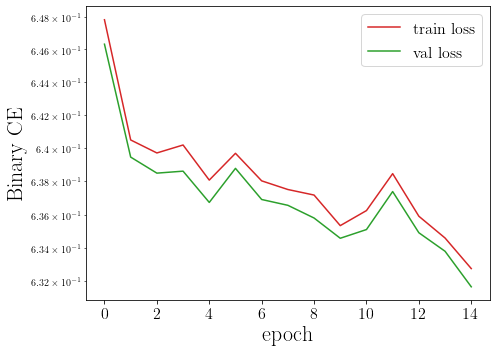

In [67]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

Next we want to look at how good this classifier is at tagging the signal events.  We do this in the exact same way as we do for a supervised classifier.  Note that while the classifier is trained on bin labels, the performance is evaluated on truth labels.

In [68]:
test_pred = model( X_test_p ).detach()

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

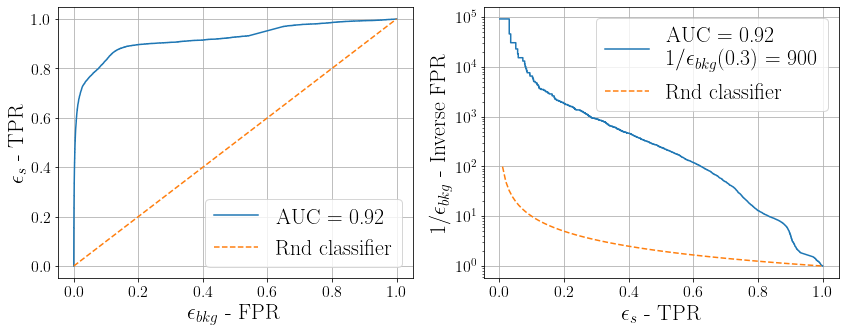

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve( y_test, test_pred )
auc_score = roc_auc_score( y_test, test_pred )
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

These results aren't bad given that we did not use truth labels in the training!

However this dataset has quite a lot of signal events for an anomaly detection problem, we call this signal-to-background ratio the S/B.  And in the case above it is 10%!

In [30]:
y_train.sum(), (1.0-y_train).sum(), str( round( ( y_train.sum() / (1.0-y_train).sum() )*100, 2 ) ) + "%"

(81725, 818275.0, '9.99%')

Next we will lower this to see how well the classifier performs.

## Lowering the S/B $\rightarrow$ less signal events

Let's re-define our dataset so that we can specify the S/B we want.

In [31]:
class cwola_data_sb( Dataset ):
    
    def __init__( self, data, labels,  bins, sb ):
        self.data = data
        self.labels = labels
        self.bins = bins
        self.sb = sb
        
        if self.sb>0.098:
            raise Exception( "S/B is too large, choose <= 0.098" )
        
        self.nbkg = int( (1.0-self.labels).sum() )
        self.nsig = int( self.labels.sum() )
        self.nsig_new = int( round( self.sb * self.nbkg ) )
        self.nsig_del = int( self.nsig - self.nsig_new )
        self.del_indx = np.where( self.labels == 1.0 )[0][0:self.nsig_del]
        self.data_cut = np.delete( self.data, self.del_indx, axis=0 )
        self.labels_cut = np.delete( self.labels, self.del_indx, axis=0 )
        self.bins_cut = np.delete( self.bins, self.del_indx, axis=0 )

    def __len__(self):
        return len(self.labels_cut)

    def __getitem__(self, idx):
        return self.data_cut[idx], self.labels_cut[idx], self.bins_cut[idx]

Now we can re-define our datasets and dataloaders with the lower S/B.

Note that we don't need to lower the S/B for testing, since this dataset is only used to get the performance.

In [32]:
trn_dataset_sb5pc = cwola_data_sb( X_train_p, y_train_p, b_train_p, 0.05 )
val_dataset_sb5pc = cwola_data_sb( X_val_p, y_val_p, b_val_p, 0.05 )
tst_dataset = cwola_data_sb( X_test_p, y_test_p, b_test_p, 0.098 )

In [33]:
trn_dataloader_sb5pc = DataLoader( trn_dataset_sb5pc, batch_size=64, shuffle=True )
val_dataloader_sb5pc = DataLoader( val_dataset_sb5pc, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

In [34]:
print( "train S/B: " + str( np.round( ( trn_dataset_sb5pc.labels_cut.sum() / (1.0-trn_dataset_sb5pc.labels_cut).sum() )*100, 2 ).item() ) + "%" )
print( "val S/B: " + str( np.round( ( val_dataset_sb5pc.labels_cut.sum() / (1.0-val_dataset_sb5pc.labels_cut).sum() )*100, 2 ).item() ) + "%" )
print( "test S/B: " + str( np.round( ( tst_dataset.labels_cut.sum() / (1.0-tst_dataset.labels_cut).sum() )*100, 2 ).item() ) + "%" )


train S/B: 5.0%
val S/B: 5.0%
test S/B: 9.800000190734863%


In [35]:
trn_dataset_sb5pc.data_cut.shape, trn_dataset_sb5pc.labels_cut.shape, trn_dataset_sb5pc.bins_cut.shape

(torch.Size([859189, 4]), torch.Size([859189, 1]), torch.Size([859189, 1]))

### S/B = 5%

In [36]:
trn_dataset_sb = cwola_data_sb( X_train_p, y_train_p, b_train_p, 0.05 )
val_dataset_sb = cwola_data_sb( X_val_p, y_val_p, b_val_p, 0.05 )

trn_dataloader_sb = DataLoader( trn_dataset_sb, batch_size=64, shuffle=True )
val_dataloader_sb = DataLoader( val_dataset_sb, batch_size=64, shuffle=True )

print( "train S/B: " + str( np.round( ( trn_dataset_sb.labels_cut.sum() / (1.0-trn_dataset_sb.labels_cut).sum() )*100, 2 ).item() ) + "%" )
print( "val S/B: " + str( np.round( ( val_dataset_sb.labels_cut.sum() / (1.0-val_dataset_sb.labels_cut).sum() )*100, 2 ).item() ) + "%" )

# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 15

# re-initialise the model and the optimizer
model_sb5pc = cwolaNet( 4, 64 ).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model_sb5pc.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader_sb, model_sb5pc, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader_sb, model_sb5pc, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader_sb, model_sb5pc, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

train S/B: 5.0%
val S/B: 5.0%
-----------------------------------------------
model architecture 
-----------------------------------------------
cwolaNet(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (relu_1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): ReLU()
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 1.596361  [    0/859189]
current batch loss: 0.666138  [ 6400/859189]
current batch loss: 0.756707  [12800/859189]
current batch loss: 0.692432  [19200/859189]
current batch loss: 0.697127  [25600/859189]
current batch loss: 0.747289  [32000/859189]
current batch loss: 0.663066  [38400/859189]
current batch loss: 0.701795  [44800/859189]
current batch loss: 0.668573  [51200/859189]
current batch loss: 0.659585  [57600/859189]
current batch loss: 0.698174  [64000/859189]
current batch loss

current batch loss: 0.661018  [179200/859189]
current batch loss: 0.593712  [185600/859189]
current batch loss: 0.754460  [192000/859189]
current batch loss: 0.689322  [198400/859189]
current batch loss: 0.651354  [204800/859189]
current batch loss: 0.604223  [211200/859189]
current batch loss: 0.631398  [217600/859189]
current batch loss: 0.638226  [224000/859189]
current batch loss: 0.693133  [230400/859189]
current batch loss: 0.592211  [236800/859189]
current batch loss: 0.637351  [243200/859189]
current batch loss: 0.658600  [249600/859189]
current batch loss: 0.627523  [256000/859189]
current batch loss: 0.662118  [262400/859189]
current batch loss: 0.614945  [268800/859189]
current batch loss: 0.575369  [275200/859189]
current batch loss: 0.739450  [281600/859189]
current batch loss: 0.643759  [288000/859189]
current batch loss: 0.647126  [294400/859189]
current batch loss: 0.599073  [300800/859189]
current batch loss: 0.671400  [307200/859189]
current batch loss: 0.622052  [313

current batch loss: 0.598076  [422400/859189]
current batch loss: 0.696429  [428800/859189]
current batch loss: 0.627629  [435200/859189]
current batch loss: 0.618278  [441600/859189]
current batch loss: 0.618109  [448000/859189]
current batch loss: 0.627683  [454400/859189]
current batch loss: 0.623711  [460800/859189]
current batch loss: 0.614366  [467200/859189]
current batch loss: 0.624000  [473600/859189]
current batch loss: 0.662182  [480000/859189]
current batch loss: 0.663195  [486400/859189]
current batch loss: 0.654448  [492800/859189]
current batch loss: 0.668126  [499200/859189]
current batch loss: 0.708343  [505600/859189]
current batch loss: 0.639751  [512000/859189]
current batch loss: 0.632477  [518400/859189]
current batch loss: 0.706379  [524800/859189]
current batch loss: 0.676077  [531200/859189]
current batch loss: 0.678666  [537600/859189]
current batch loss: 0.625320  [544000/859189]
current batch loss: 0.641415  [550400/859189]
current batch loss: 0.658851  [556

current batch loss: 0.653063  [659200/859189]
current batch loss: 0.627621  [665600/859189]
current batch loss: 0.653965  [672000/859189]
current batch loss: 0.593562  [678400/859189]
current batch loss: 0.632030  [684800/859189]
current batch loss: 0.621558  [691200/859189]
current batch loss: 0.658025  [697600/859189]
current batch loss: 0.609226  [704000/859189]
current batch loss: 0.653391  [710400/859189]
current batch loss: 0.704024  [716800/859189]
current batch loss: 0.619264  [723200/859189]
current batch loss: 0.637422  [729600/859189]
current batch loss: 0.660591  [736000/859189]
current batch loss: 0.629166  [742400/859189]
current batch loss: 0.623532  [748800/859189]
current batch loss: 0.652107  [755200/859189]
current batch loss: 0.684021  [761600/859189]
current batch loss: 0.657105  [768000/859189]
current batch loss: 0.633847  [774400/859189]
current batch loss: 0.648806  [780800/859189]
current batch loss: 0.670494  [787200/859189]
current batch loss: 0.652230  [793

current batch loss: 0.679781  [12800/859189]
current batch loss: 0.661520  [19200/859189]
current batch loss: 0.633860  [25600/859189]
current batch loss: 0.660506  [32000/859189]
current batch loss: 0.618847  [38400/859189]
current batch loss: 0.669307  [44800/859189]
current batch loss: 0.612893  [51200/859189]
current batch loss: 0.632969  [57600/859189]
current batch loss: 0.722240  [64000/859189]
current batch loss: 0.658347  [70400/859189]
current batch loss: 0.646259  [76800/859189]
current batch loss: 0.651750  [83200/859189]
current batch loss: 0.687510  [89600/859189]
current batch loss: 0.635639  [96000/859189]
current batch loss: 0.654761  [102400/859189]
current batch loss: 0.696777  [108800/859189]
current batch loss: 0.632540  [115200/859189]
current batch loss: 0.629003  [121600/859189]
current batch loss: 0.661050  [128000/859189]
current batch loss: 0.720799  [134400/859189]
current batch loss: 0.660418  [140800/859189]
current batch loss: 0.625629  [147200/859189]
cu

current batch loss: 0.638950  [256000/859189]
current batch loss: 0.682486  [262400/859189]
current batch loss: 0.620352  [268800/859189]
current batch loss: 0.649982  [275200/859189]
current batch loss: 0.689718  [281600/859189]
current batch loss: 0.688180  [288000/859189]
current batch loss: 0.676195  [294400/859189]
current batch loss: 0.670494  [300800/859189]
current batch loss: 0.687761  [307200/859189]
current batch loss: 0.636803  [313600/859189]
current batch loss: 0.720385  [320000/859189]
current batch loss: 0.732815  [326400/859189]
current batch loss: 0.704986  [332800/859189]
current batch loss: 0.671591  [339200/859189]
current batch loss: 0.674982  [345600/859189]
current batch loss: 0.642600  [352000/859189]
current batch loss: 0.637387  [358400/859189]
current batch loss: 0.700284  [364800/859189]
current batch loss: 0.624117  [371200/859189]
current batch loss: 0.646808  [377600/859189]
current batch loss: 0.645611  [384000/859189]
current batch loss: 0.691598  [390

current batch loss: 0.603055  [499200/859189]
current batch loss: 0.663706  [505600/859189]
current batch loss: 0.644677  [512000/859189]
current batch loss: 0.701543  [518400/859189]
current batch loss: 0.636951  [524800/859189]
current batch loss: 0.693195  [531200/859189]
current batch loss: 0.648783  [537600/859189]
current batch loss: 0.677993  [544000/859189]
current batch loss: 0.605047  [550400/859189]
current batch loss: 0.637004  [556800/859189]
current batch loss: 0.683131  [563200/859189]
current batch loss: 0.601073  [569600/859189]
current batch loss: 0.708407  [576000/859189]
current batch loss: 0.666099  [582400/859189]
current batch loss: 0.619170  [588800/859189]
current batch loss: 0.641441  [595200/859189]
current batch loss: 0.617308  [601600/859189]
current batch loss: 0.640818  [608000/859189]
current batch loss: 0.666969  [614400/859189]
current batch loss: 0.690383  [620800/859189]
current batch loss: 0.642328  [627200/859189]
current batch loss: 0.693455  [633

current batch loss: 0.630453  [742400/859189]
current batch loss: 0.638058  [748800/859189]
current batch loss: 0.681675  [755200/859189]
current batch loss: 0.624365  [761600/859189]
current batch loss: 0.656940  [768000/859189]
current batch loss: 0.604273  [774400/859189]
current batch loss: 0.572577  [780800/859189]
current batch loss: 0.639063  [787200/859189]
current batch loss: 0.637788  [793600/859189]
current batch loss: 0.607889  [800000/859189]
current batch loss: 0.694275  [806400/859189]
current batch loss: 0.583148  [812800/859189]
current batch loss: 0.661098  [819200/859189]
current batch loss: 0.553133  [825600/859189]
current batch loss: 0.601651  [832000/859189]
current batch loss: 0.566014  [838400/859189]
current batch loss: 0.743499  [844800/859189]
current batch loss: 0.661556  [851200/859189]
current batch loss: 0.656501  [857600/859189]
-----------------------------------------------
avg trn loss per batch: 0.649604
---------------------------------------------

current batch loss: 0.633915  [76800/859189]
current batch loss: 0.590044  [83200/859189]
current batch loss: 0.646856  [89600/859189]
current batch loss: 0.680629  [96000/859189]
current batch loss: 0.624960  [102400/859189]
current batch loss: 0.572929  [108800/859189]
current batch loss: 0.676541  [115200/859189]
current batch loss: 0.655222  [121600/859189]
current batch loss: 0.640885  [128000/859189]
current batch loss: 0.609571  [134400/859189]
current batch loss: 0.711928  [140800/859189]
current batch loss: 0.709977  [147200/859189]
current batch loss: 0.620571  [153600/859189]
current batch loss: 0.650155  [160000/859189]
current batch loss: 0.664517  [166400/859189]
current batch loss: 0.664822  [172800/859189]
current batch loss: 0.667407  [179200/859189]
current batch loss: 0.678712  [185600/859189]
current batch loss: 0.627039  [192000/859189]
current batch loss: 0.585029  [198400/859189]
current batch loss: 0.637679  [204800/859189]
current batch loss: 0.676399  [211200/

current batch loss: 0.670805  [320000/859189]
current batch loss: 0.775169  [326400/859189]
current batch loss: 0.644679  [332800/859189]
current batch loss: 0.686056  [339200/859189]
current batch loss: 0.610987  [345600/859189]
current batch loss: 0.673007  [352000/859189]
current batch loss: 0.652028  [358400/859189]
current batch loss: 0.595746  [364800/859189]
current batch loss: 0.683961  [371200/859189]
current batch loss: 0.672336  [377600/859189]
current batch loss: 0.633647  [384000/859189]
current batch loss: 0.632763  [390400/859189]
current batch loss: 0.673912  [396800/859189]
current batch loss: 0.632324  [403200/859189]
current batch loss: 0.686901  [409600/859189]
current batch loss: 0.630999  [416000/859189]
current batch loss: 0.649120  [422400/859189]
current batch loss: 0.667073  [428800/859189]
current batch loss: 0.679165  [435200/859189]
current batch loss: 0.596368  [441600/859189]
current batch loss: 0.613560  [448000/859189]
current batch loss: 0.679697  [454

current batch loss: 0.638598  [563200/859189]
current batch loss: 0.716224  [569600/859189]
current batch loss: 0.677547  [576000/859189]
current batch loss: 0.692664  [582400/859189]
current batch loss: 0.657966  [588800/859189]
current batch loss: 0.618032  [595200/859189]
current batch loss: 0.627616  [601600/859189]
current batch loss: 0.703122  [608000/859189]
current batch loss: 0.662338  [614400/859189]
current batch loss: 0.634431  [620800/859189]
current batch loss: 0.644993  [627200/859189]
current batch loss: 0.660051  [633600/859189]
current batch loss: 0.592799  [640000/859189]
current batch loss: 0.600320  [646400/859189]
current batch loss: 0.673426  [652800/859189]
current batch loss: 0.633207  [659200/859189]
current batch loss: 0.645095  [665600/859189]
current batch loss: 0.713609  [672000/859189]
current batch loss: 0.695124  [678400/859189]
current batch loss: 0.619064  [684800/859189]
current batch loss: 0.664541  [691200/859189]
current batch loss: 0.695905  [697

current batch loss: 0.586634  [806400/859189]
current batch loss: 0.676128  [812800/859189]
current batch loss: 0.647444  [819200/859189]
current batch loss: 0.687266  [825600/859189]
current batch loss: 0.652879  [832000/859189]
current batch loss: 0.713267  [838400/859189]
current batch loss: 0.669239  [844800/859189]
current batch loss: 0.613604  [851200/859189]
current batch loss: 0.653029  [857600/859189]
-----------------------------------------------
avg trn loss per batch: 0.648054
-----------------------------------------------
avg val loss per batch: 0.647576
-----------------------------------------------
|
-----------------------------------------------
Epoch 15
-----------------------------------------------
current batch loss: 0.579045  [    0/859189]
current batch loss: 0.601053  [ 6400/859189]
current batch loss: 0.695562  [12800/859189]
current batch loss: 0.691413  [19200/859189]
current batch loss: 0.660087  [25600/859189]
current batch loss: 0.668647  [32000/859189]

In [37]:
test_pred_sb5pc = model_sb5pc( X_test_p ).detach()

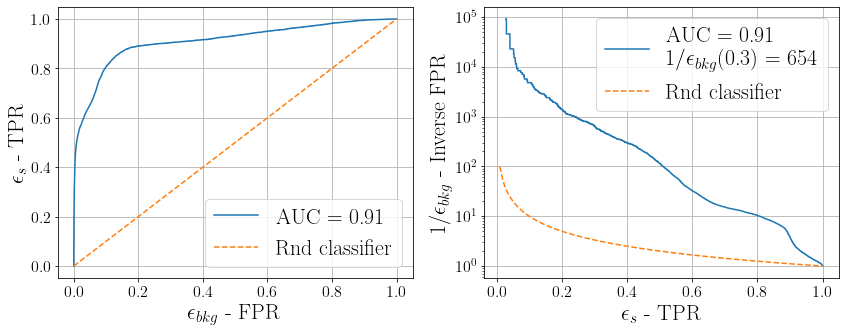

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve( y_test, test_pred_sb5pc )
auc_score = roc_auc_score( y_test, test_pred_sb5pc )
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

### S/B = 1%

In [39]:
trn_dataset_sb = cwola_data_sb( X_train_p, y_train_p, b_train_p, 0.01 )
val_dataset_sb = cwola_data_sb( X_val_p, y_val_p, b_val_p, 0.01 )

trn_dataloader_sb = DataLoader( trn_dataset_sb, batch_size=64, shuffle=True )
val_dataloader_sb = DataLoader( val_dataset_sb, batch_size=64, shuffle=True )

print( "train S/B: " + str( np.round( ( trn_dataset_sb.labels_cut.sum() / (1.0-trn_dataset_sb.labels_cut).sum() )*100, 2 ).item() ) + "%" )
print( "val S/B: " + str( np.round( ( val_dataset_sb.labels_cut.sum() / (1.0-val_dataset_sb.labels_cut).sum() )*100, 2 ).item() ) + "%" )

# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 15

# re-initialise the model and the optimizer
model_sb1pc = cwolaNet( 4, 64 ).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model_sb1pc.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader_sb, model_sb1pc, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader_sb, model_sb1pc, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader_sb, model_sb1pc, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

train S/B: 1.0%
val S/B: 1.0%
-----------------------------------------------
model architecture 
-----------------------------------------------
cwolaNet(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (relu_1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): ReLU()
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 6.054812  [    0/826458]
current batch loss: 0.707391  [ 6400/826458]
current batch loss: 0.682145  [12800/826458]
current batch loss: 0.723682  [19200/826458]
current batch loss: 0.715006  [25600/826458]
current batch loss: 0.827510  [32000/826458]
current batch loss: 0.671934  [38400/826458]
current batch loss: 0.632651  [44800/826458]
current batch loss: 0.712850  [51200/826458]
current batch loss: 0.740941  [57600/826458]
current batch loss: 0.650049  [64000/826458]
current batch loss

current batch loss: 0.630399  [204800/826458]
current batch loss: 0.683260  [211200/826458]
current batch loss: 0.670509  [217600/826458]
current batch loss: 0.642496  [224000/826458]
current batch loss: 0.627049  [230400/826458]
current batch loss: 0.652974  [236800/826458]
current batch loss: 0.660341  [243200/826458]
current batch loss: 0.668526  [249600/826458]
current batch loss: 0.677479  [256000/826458]
current batch loss: 0.599560  [262400/826458]
current batch loss: 0.679347  [268800/826458]
current batch loss: 0.598778  [275200/826458]
current batch loss: 0.644323  [281600/826458]
current batch loss: 0.675706  [288000/826458]
current batch loss: 0.575044  [294400/826458]
current batch loss: 0.611424  [300800/826458]
current batch loss: 0.660107  [307200/826458]
current batch loss: 0.695020  [313600/826458]
current batch loss: 0.650960  [320000/826458]
current batch loss: 0.670954  [326400/826458]
current batch loss: 0.675951  [332800/826458]
current batch loss: 0.707262  [339

current batch loss: 0.667762  [480000/826458]
current batch loss: 0.740214  [486400/826458]
current batch loss: 0.674839  [492800/826458]
current batch loss: 0.560611  [499200/826458]
current batch loss: 0.616275  [505600/826458]
current batch loss: 0.689086  [512000/826458]
current batch loss: 0.661538  [518400/826458]
current batch loss: 0.608999  [524800/826458]
current batch loss: 0.675478  [531200/826458]
current batch loss: 0.664823  [537600/826458]
current batch loss: 0.582446  [544000/826458]
current batch loss: 0.623642  [550400/826458]
current batch loss: 0.629904  [556800/826458]
current batch loss: 0.628068  [563200/826458]
current batch loss: 0.700459  [569600/826458]
current batch loss: 0.613220  [576000/826458]
current batch loss: 0.691125  [582400/826458]
current batch loss: 0.663884  [588800/826458]
current batch loss: 0.602766  [595200/826458]
current batch loss: 0.693460  [601600/826458]
current batch loss: 0.692691  [608000/826458]
current batch loss: 0.675978  [614

current batch loss: 0.624988  [755200/826458]
current batch loss: 0.671056  [761600/826458]
current batch loss: 0.592909  [768000/826458]
current batch loss: 0.652118  [774400/826458]
current batch loss: 0.620771  [780800/826458]
current batch loss: 0.635960  [787200/826458]
current batch loss: 0.718262  [793600/826458]
current batch loss: 0.659640  [800000/826458]
current batch loss: 0.683943  [806400/826458]
current batch loss: 0.621394  [812800/826458]
current batch loss: 0.666680  [819200/826458]
current batch loss: 0.668537  [825600/826458]
-----------------------------------------------
avg trn loss per batch: 0.653126
-----------------------------------------------
avg val loss per batch: 0.652723
-----------------------------------------------
|
-----------------------------------------------
Epoch 5
-----------------------------------------------
current batch loss: 0.603484  [    0/826458]
current batch loss: 0.688957  [ 6400/826458]
current batch loss: 0.629629  [12800/82645

current batch loss: 0.708537  [160000/826458]
current batch loss: 0.629578  [166400/826458]
current batch loss: 0.587397  [172800/826458]
current batch loss: 0.606974  [179200/826458]
current batch loss: 0.622032  [185600/826458]
current batch loss: 0.687147  [192000/826458]
current batch loss: 0.634994  [198400/826458]
current batch loss: 0.671359  [204800/826458]
current batch loss: 0.720260  [211200/826458]
current batch loss: 0.715289  [217600/826458]
current batch loss: 0.641536  [224000/826458]
current batch loss: 0.646813  [230400/826458]
current batch loss: 0.645145  [236800/826458]
current batch loss: 0.595571  [243200/826458]
current batch loss: 0.664197  [249600/826458]
current batch loss: 0.631216  [256000/826458]
current batch loss: 0.651088  [262400/826458]
current batch loss: 0.698652  [268800/826458]
current batch loss: 0.688233  [275200/826458]
current batch loss: 0.621939  [281600/826458]
current batch loss: 0.582646  [288000/826458]
current batch loss: 0.680941  [294

current batch loss: 0.681282  [435200/826458]
current batch loss: 0.644907  [441600/826458]
current batch loss: 0.640919  [448000/826458]
current batch loss: 0.644056  [454400/826458]
current batch loss: 0.641005  [460800/826458]
current batch loss: 0.626490  [467200/826458]
current batch loss: 0.650528  [473600/826458]
current batch loss: 0.635959  [480000/826458]
current batch loss: 0.652627  [486400/826458]
current batch loss: 0.736398  [492800/826458]
current batch loss: 0.723159  [499200/826458]
current batch loss: 0.659646  [505600/826458]
current batch loss: 0.633560  [512000/826458]
current batch loss: 0.636884  [518400/826458]
current batch loss: 0.680562  [524800/826458]
current batch loss: 0.686008  [531200/826458]
current batch loss: 0.628560  [537600/826458]
current batch loss: 0.643172  [544000/826458]
current batch loss: 0.622736  [550400/826458]
current batch loss: 0.624150  [556800/826458]
current batch loss: 0.597231  [563200/826458]
current batch loss: 0.628307  [569

current batch loss: 0.625623  [704000/826458]
current batch loss: 0.651934  [710400/826458]
current batch loss: 0.581252  [716800/826458]
current batch loss: 0.632465  [723200/826458]
current batch loss: 0.591198  [729600/826458]
current batch loss: 0.678253  [736000/826458]
current batch loss: 0.573295  [742400/826458]
current batch loss: 0.712986  [748800/826458]
current batch loss: 0.632812  [755200/826458]
current batch loss: 0.687277  [761600/826458]
current batch loss: 0.669723  [768000/826458]
current batch loss: 0.602520  [774400/826458]
current batch loss: 0.667909  [780800/826458]
current batch loss: 0.682464  [787200/826458]
current batch loss: 0.654933  [793600/826458]
current batch loss: 0.692535  [800000/826458]
current batch loss: 0.674984  [806400/826458]
current batch loss: 0.638385  [812800/826458]
current batch loss: 0.705876  [819200/826458]
current batch loss: 0.679715  [825600/826458]
-----------------------------------------------
avg trn loss per batch: 0.652891

current batch loss: 0.615671  [102400/826458]
current batch loss: 0.686460  [108800/826458]
current batch loss: 0.648471  [115200/826458]
current batch loss: 0.655054  [121600/826458]
current batch loss: 0.667401  [128000/826458]
current batch loss: 0.661458  [134400/826458]
current batch loss: 0.670761  [140800/826458]
current batch loss: 0.663711  [147200/826458]
current batch loss: 0.683231  [153600/826458]
current batch loss: 0.690483  [160000/826458]
current batch loss: 0.672880  [166400/826458]
current batch loss: 0.659813  [172800/826458]
current batch loss: 0.707330  [179200/826458]
current batch loss: 0.673304  [185600/826458]
current batch loss: 0.652382  [192000/826458]
current batch loss: 0.624956  [198400/826458]
current batch loss: 0.629452  [204800/826458]
current batch loss: 0.683522  [211200/826458]
current batch loss: 0.653739  [217600/826458]
current batch loss: 0.642421  [224000/826458]
current batch loss: 0.647797  [230400/826458]
current batch loss: 0.687400  [236

current batch loss: 0.650436  [371200/826458]
current batch loss: 0.653019  [377600/826458]
current batch loss: 0.643972  [384000/826458]
current batch loss: 0.684560  [390400/826458]
current batch loss: 0.577478  [396800/826458]
current batch loss: 0.586054  [403200/826458]
current batch loss: 0.638045  [409600/826458]
current batch loss: 0.667089  [416000/826458]
current batch loss: 0.649708  [422400/826458]
current batch loss: 0.648542  [428800/826458]
current batch loss: 0.671539  [435200/826458]
current batch loss: 0.572338  [441600/826458]
current batch loss: 0.669608  [448000/826458]
current batch loss: 0.665999  [454400/826458]
current batch loss: 0.636233  [460800/826458]
current batch loss: 0.633263  [467200/826458]
current batch loss: 0.703304  [473600/826458]
current batch loss: 0.687370  [480000/826458]
current batch loss: 0.652935  [486400/826458]
current batch loss: 0.636478  [492800/826458]
current batch loss: 0.593052  [499200/826458]
current batch loss: 0.711970  [505

current batch loss: 0.567650  [640000/826458]
current batch loss: 0.679799  [646400/826458]
current batch loss: 0.611875  [652800/826458]
current batch loss: 0.662382  [659200/826458]
current batch loss: 0.694146  [665600/826458]
current batch loss: 0.684326  [672000/826458]
current batch loss: 0.685454  [678400/826458]
current batch loss: 0.710573  [684800/826458]
current batch loss: 0.697015  [691200/826458]
current batch loss: 0.619961  [697600/826458]
current batch loss: 0.662541  [704000/826458]
current batch loss: 0.644174  [710400/826458]
current batch loss: 0.697409  [716800/826458]
current batch loss: 0.645180  [723200/826458]
current batch loss: 0.711047  [729600/826458]
current batch loss: 0.658135  [736000/826458]
current batch loss: 0.645783  [742400/826458]
current batch loss: 0.667314  [748800/826458]
current batch loss: 0.599987  [755200/826458]
current batch loss: 0.694560  [761600/826458]
current batch loss: 0.684667  [768000/826458]
current batch loss: 0.658372  [774

current batch loss: 0.686998  [38400/826458]
current batch loss: 0.665465  [44800/826458]
current batch loss: 0.634364  [51200/826458]
current batch loss: 0.641380  [57600/826458]
current batch loss: 0.661932  [64000/826458]
current batch loss: 0.657348  [70400/826458]
current batch loss: 0.674261  [76800/826458]
current batch loss: 0.669159  [83200/826458]
current batch loss: 0.657515  [89600/826458]
current batch loss: 0.611535  [96000/826458]
current batch loss: 0.659487  [102400/826458]
current batch loss: 0.669787  [108800/826458]
current batch loss: 0.598283  [115200/826458]
current batch loss: 0.687601  [121600/826458]
current batch loss: 0.626745  [128000/826458]
current batch loss: 0.687299  [134400/826458]
current batch loss: 0.648127  [140800/826458]
current batch loss: 0.697371  [147200/826458]
current batch loss: 0.632698  [153600/826458]
current batch loss: 0.618476  [160000/826458]
current batch loss: 0.630920  [166400/826458]
current batch loss: 0.661645  [172800/826458

current batch loss: 0.649869  [307200/826458]
current batch loss: 0.647312  [313600/826458]
current batch loss: 0.720732  [320000/826458]
current batch loss: 0.597820  [326400/826458]
current batch loss: 0.687372  [332800/826458]
current batch loss: 0.623710  [339200/826458]
current batch loss: 0.674666  [345600/826458]
current batch loss: 0.639814  [352000/826458]
current batch loss: 0.608868  [358400/826458]
current batch loss: 0.634586  [364800/826458]
current batch loss: 0.643876  [371200/826458]
current batch loss: 0.588931  [377600/826458]
current batch loss: 0.614397  [384000/826458]
current batch loss: 0.650924  [390400/826458]
current batch loss: 0.627213  [396800/826458]
current batch loss: 0.645783  [403200/826458]
current batch loss: 0.626789  [409600/826458]
current batch loss: 0.630119  [416000/826458]
current batch loss: 0.647393  [422400/826458]
current batch loss: 0.653392  [428800/826458]
current batch loss: 0.716629  [435200/826458]
current batch loss: 0.659550  [441

In [40]:
test_pred_sb1pc = model_sb1pc( X_test_p ).detach()

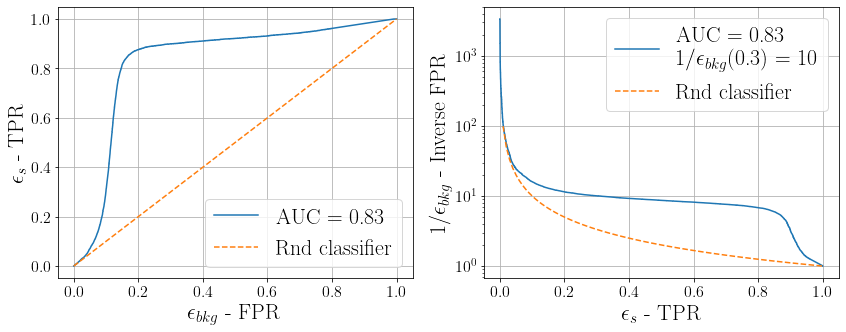

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve( y_test, test_pred_sb1pc )
auc_score = roc_auc_score( y_test, test_pred_sb1pc )
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

Now we can see that the performance really does get a lot worse at lower S/B.

### Comparison

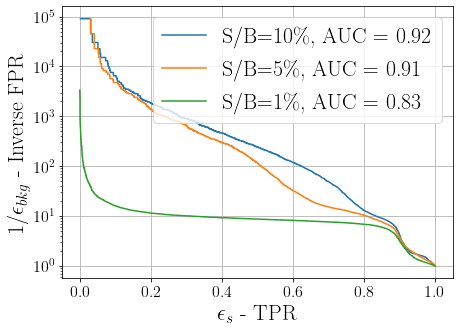

In [71]:
fig, ax = plt.subplots( figsize=(7,5))

fpr_sb10pc, tpr_sb10pc, th_sb10pc = roc_curve( y_test, test_pred )
fpr_sb5pc, tpr_sb5pc, th_sb5pc = roc_curve( y_test, test_pred_sb5pc )
fpr_sb1pc, tpr_sb1pc, th_sb1pc = roc_curve( y_test, test_pred_sb1pc )

auc_score_sb10pc = roc_auc_score( y_test, test_pred )
auc_score_sb5pc = roc_auc_score( y_test, test_pred_sb5pc )
auc_score_sb1pc = roc_auc_score( y_test, test_pred_sb1pc )

rnd_class = np.linspace(0, 1, 100)

ax.plot(tpr_sb10pc, 1/fpr_sb10pc, label='S/B=10\%, AUC = {:.2f}'.format(auc_score_sb10pc))
ax.plot(tpr_sb5pc, 1/fpr_sb5pc, label='S/B=5\%, AUC = {:.2f}'.format(auc_score_sb5pc))
ax.plot(tpr_sb1pc, 1/fpr_sb1pc, label='S/B=1\%, AUC = {:.2f}'.format(auc_score_sb1pc))
#ax.plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax.set_yscale('log')

ax.set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax.set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
ax.legend(prop=axislabelfont)
ax.tick_params(labelsize=axisfontsize)
ax.grid('on')

## Correlations & 'optimal CWoLa'

First, let's make the dataset.

We will only use the signal window data here, and split it artificially into different 'bins'.

Check how many signal events in the training data:

In [43]:
trn_dat_sw.shape, trn_lbs_sw.sum()

((380294, 4), 76608)

In [44]:
trn_len = int( trn_lbs_sw.shape[0] )
half_trn_len = int( trn_lbs_sw.shape[0]/2 )
trn_lbs_sw[0:half_trn_len].sum()

38432

Check how many signal events in the validation data:

In [45]:
val_dat_sw.shape, val_lbs_sw.sum()

((42375, 4), 8613)

In [46]:
val_len = int( val_lbs_sw.shape[0] )
half_val_len = int( val_lbs_sw.shape[0]/2 )
val_lbs_sw[0:half_val_len].sum()

4313

Check how many signal events in the testing data:

In [47]:
tst_dat_sw.shape, tst_lbs_sw.sum()

((42020, 4), 8481)

In [48]:
tst_len = int( tst_lbs_sw.shape[0] )
half_tst_len = int( tst_lbs_sw.shape[0]/2 )
tst_lbs_sw[0:half_tst_len].sum()

4274

Now let's define the training, validation, and testing data.

In [49]:
X_train_oc = trn_dat_sw.copy()
y_train_oc = trn_lbs_sw.copy()
b_train_oc = np.concatenate( ( np.ones( half_trn_len ), np.zeros( trn_len - half_trn_len ) ), axis=0 )
b_train_oc[ np.where( y_train_oc==1.0 ) ] = 1.0

X_val_oc = val_dat_sw.copy()
y_val_oc = val_lbs_sw.copy()
b_val_oc = np.concatenate( ( np.ones( half_val_len ), np.zeros( val_len - half_val_len ) ), axis=0 )
b_val_oc[ np.where( y_val_oc==1.0 ) ] = 1.0

X_test_oc = tst_dat_sw.copy()
y_test_oc = tst_lbs_sw.copy()
b_test_oc = np.concatenate( ( np.ones( half_tst_len ), np.zeros( tst_len - half_tst_len ) ), axis=0 )
b_test_oc[ np.where( y_test_oc==1.0 ) ] = 1.0

Check the shapes and sums.

In [50]:
X_train_oc.shape, y_train_oc.shape, b_train_oc.shape, b_train_oc.sum(), (1-y_train_oc).sum(), y_train_oc.sum()

((380294, 4), (380294,), (380294,), 228323.0, 303686, 76608)

In [51]:
X_val_oc.shape, y_val_oc.shape, b_val_oc.shape, b_val_oc.sum(), (1-y_val_oc).sum(), y_val_oc.sum()

((42375, 4), (42375,), (42375,), 25487.0, 33762, 8613)

In [52]:
X_test_oc.shape, y_test_oc.shape, b_test_oc.shape, b_test_oc.sum(), (1-y_test_oc).sum(), y_test_oc.sum()

((42020, 4), (42020,), (42020,), 25217.0, 33539, 8481)

But there are too many signal events.  We want the S/B to be the same as before, i.e. 10%.  Let's delete some of them.

In [53]:
trn_nbkg_oc = ( 1.0 - y_train_oc ).sum()
trn_nsig_oc = y_train_oc.sum()
trn_ndel_oc = int( trn_nsig_oc - 0.1*trn_nbkg_oc )
trn_del_ind_oc = np.where( y_train_oc==1.0 )[0][0:trn_ndel_oc]
X_train_oc = np.delete( X_train_oc, trn_del_ind_oc, axis=0 )
y_train_oc = np.delete( y_train_oc, trn_del_ind_oc, axis=0 )
b_train_oc = np.delete( b_train_oc, trn_del_ind_oc, axis=0 )

val_nbkg_oc = ( 1.0 - y_val_oc ).sum()
val_nsig_oc = y_val_oc.sum()
val_ndel_oc = int( val_nsig_oc - 0.1*val_nbkg_oc )
val_del_ind_oc = np.where( y_val_oc==1.0 )[0][0:val_ndel_oc]
X_val_oc = np.delete( X_val_oc, val_del_ind_oc, axis=0 )
y_val_oc = np.delete( y_val_oc, val_del_ind_oc, axis=0 )
b_val_oc = np.delete( b_val_oc, val_del_ind_oc, axis=0 )

tst_nbkg_oc = ( 1.0 - y_test_oc ).sum()
tst_nsig_oc = y_test_oc.sum()
tst_ndel_oc = int( tst_nsig_oc - 0.1*tst_nbkg_oc )
tst_del_ind_oc = np.where( y_test_oc==1.0 )[0][0:tst_ndel_oc]
X_test_oc = np.delete( X_test_oc, tst_del_ind_oc, axis=0 )
y_test_oc = np.delete( y_test_oc, tst_del_ind_oc, axis=0 )
b_test_oc = np.delete( b_test_oc, tst_del_ind_oc, axis=0 )

Check the shapes and sums again.

In [54]:
X_train_oc.shape, y_train_oc.shape, b_train_oc.shape, b_train_oc.sum(), (1-y_train_oc).sum(), y_train_oc.sum()

((334055, 4), (334055,), (334055,), 182084.0, 303686, 30369)

In [55]:
X_val_oc.shape, y_val_oc.shape, b_val_oc.shape, b_val_oc.sum(), (1-y_val_oc).sum(), y_val_oc.sum()

((37139, 4), (37139,), (37139,), 20251.0, 33762, 3377)

In [56]:
X_test_oc.shape, y_test_oc.shape, b_test_oc.shape, b_test_oc.sum(), (1-y_test_oc).sum(), y_test_oc.sum()

((36893, 4), (36893,), (36893,), 20090.0, 33539, 3354)

Now let's put them in datasets and dataloaders.

In [57]:
X_train_oc_p = torch.Tensor( X_train_oc )
y_train_oc_p = torch.Tensor( y_train_oc ).unsqueeze(-1)
b_train_oc_p = torch.Tensor( b_train_oc ).unsqueeze(-1)

X_val_oc_p = torch.Tensor( X_val_oc )
y_val_oc_p = torch.Tensor( y_val_oc ).unsqueeze(-1)
b_val_oc_p = torch.Tensor( b_val_oc ).unsqueeze(-1)

X_test_oc_p = torch.Tensor( X_test_oc )
y_test_oc_p = torch.Tensor( y_test_oc ).unsqueeze(-1)
b_test_oc_p = torch.Tensor( b_test_oc ).unsqueeze(-1)

In [58]:
trn_dataset_oc = cwola_data( X_train_oc_p, y_train_oc_p, b_train_oc_p )
val_dataset_oc = cwola_data( X_val_oc_p, y_val_oc_p, b_val_oc_p )
tst_dataset_oc = cwola_data( X_test_oc_p, y_test_oc_p, b_test_oc_p )

In [59]:
trn_dataloader_oc = DataLoader( trn_dataset_oc, batch_size=64, shuffle=True )
val_dataloader_oc = DataLoader( val_dataset_oc, batch_size=64, shuffle=True )
tst_dataloader_oc = DataLoader( tst_dataset_oc, batch_size=64, shuffle=True )

Now let's optimise it.

We only have ~40% of the data here, so I'm increasing the number of epochs. 

In [60]:
trn_len = X_train.shape[0]
trn_len_oc = X_train_oc.shape[0]
trn_len, trn_len_oc, trn_len_oc/trn_len, trn_len / trn_len_oc, int( 15*trn_len / trn_len_oc )

(900000, 334055, 0.37117222222222224, 2.6941671281675172, 40)

In [73]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 40

# re-initialise the model and the optimizer
model_oc = cwolaNet( 4, 64 ).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model_oc.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, model_oc, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader, model_oc, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, model_oc, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
cwolaNet(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (relu_1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (relu_2): ReLU()
  (layer3): Linear(in_features=64, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 2.362020  [    0/900000]
current batch loss: 0.648834  [ 6400/900000]
current batch loss: 0.672626  [12800/900000]
current batch loss: 0.722955  [19200/900000]
current batch loss: 0.678765  [25600/900000]
current batch loss: 0.626515  [32000/900000]
current batch loss: 0.623540  [38400/900000]
current batch loss: 0.658629  [44800/900000]
current batch loss: 0.730936  [51200/900000]
current batch loss: 0.684623  [57600/900000]
current batch loss: 0.684048  [64000/900000]
current batch loss: 0.664977  [70400/900000]
cur

current batch loss: 0.642415  [140800/900000]
current batch loss: 0.679804  [147200/900000]
current batch loss: 0.671468  [153600/900000]
current batch loss: 0.657570  [160000/900000]
current batch loss: 0.706905  [166400/900000]
current batch loss: 0.658196  [172800/900000]
current batch loss: 0.634802  [179200/900000]
current batch loss: 0.597448  [185600/900000]
current batch loss: 0.618192  [192000/900000]
current batch loss: 0.653197  [198400/900000]
current batch loss: 0.545804  [204800/900000]
current batch loss: 0.615309  [211200/900000]
current batch loss: 0.620554  [217600/900000]
current batch loss: 0.624513  [224000/900000]
current batch loss: 0.648602  [230400/900000]
current batch loss: 0.577616  [236800/900000]
current batch loss: 0.638873  [243200/900000]
current batch loss: 0.737002  [249600/900000]
current batch loss: 0.658552  [256000/900000]
current batch loss: 0.612083  [262400/900000]
current batch loss: 0.603953  [268800/900000]
current batch loss: 0.651458  [275

current batch loss: 0.641714  [345600/900000]
current batch loss: 0.620782  [352000/900000]
current batch loss: 0.646052  [358400/900000]
current batch loss: 0.725117  [364800/900000]
current batch loss: 0.645554  [371200/900000]
current batch loss: 0.662990  [377600/900000]
current batch loss: 0.622760  [384000/900000]
current batch loss: 0.587172  [390400/900000]
current batch loss: 0.637648  [396800/900000]
current batch loss: 0.628529  [403200/900000]
current batch loss: 0.713997  [409600/900000]
current batch loss: 0.608490  [416000/900000]
current batch loss: 0.615936  [422400/900000]
current batch loss: 0.666304  [428800/900000]
current batch loss: 0.708353  [435200/900000]
current batch loss: 0.612310  [441600/900000]
current batch loss: 0.591168  [448000/900000]
current batch loss: 0.724555  [454400/900000]
current batch loss: 0.579382  [460800/900000]
current batch loss: 0.601808  [467200/900000]
current batch loss: 0.656133  [473600/900000]
current batch loss: 0.584865  [480

current batch loss: 0.682218  [550400/900000]
current batch loss: 0.641802  [556800/900000]
current batch loss: 0.688235  [563200/900000]
current batch loss: 0.611098  [569600/900000]
current batch loss: 0.633244  [576000/900000]
current batch loss: 0.687024  [582400/900000]
current batch loss: 0.561944  [588800/900000]
current batch loss: 0.625899  [595200/900000]
current batch loss: 0.560178  [601600/900000]
current batch loss: 0.629178  [608000/900000]
current batch loss: 0.605407  [614400/900000]
current batch loss: 0.605940  [620800/900000]
current batch loss: 0.610528  [627200/900000]
current batch loss: 0.692517  [633600/900000]
current batch loss: 0.660598  [640000/900000]
current batch loss: 0.716291  [646400/900000]
current batch loss: 0.647621  [652800/900000]
current batch loss: 0.651474  [659200/900000]
current batch loss: 0.637915  [665600/900000]
current batch loss: 0.642571  [672000/900000]
current batch loss: 0.579958  [678400/900000]
current batch loss: 0.638758  [684

current batch loss: 0.699533  [755200/900000]
current batch loss: 0.576494  [761600/900000]
current batch loss: 0.651361  [768000/900000]
current batch loss: 0.606318  [774400/900000]
current batch loss: 0.628030  [780800/900000]
current batch loss: 0.634998  [787200/900000]
current batch loss: 0.639655  [793600/900000]
current batch loss: 0.673952  [800000/900000]
current batch loss: 0.661152  [806400/900000]
current batch loss: 0.675429  [812800/900000]
current batch loss: 0.654602  [819200/900000]
current batch loss: 0.626298  [825600/900000]
current batch loss: 0.670072  [832000/900000]
current batch loss: 0.630080  [838400/900000]
current batch loss: 0.693717  [844800/900000]
current batch loss: 0.631245  [851200/900000]
current batch loss: 0.667090  [857600/900000]
current batch loss: 0.637884  [864000/900000]
current batch loss: 0.639375  [870400/900000]
current batch loss: 0.645481  [876800/900000]
current batch loss: 0.660746  [883200/900000]
current batch loss: 0.636274  [889

current batch loss: 0.650562  [12800/900000]
current batch loss: 0.667250  [19200/900000]
current batch loss: 0.601323  [25600/900000]
current batch loss: 0.676872  [32000/900000]
current batch loss: 0.615221  [38400/900000]
current batch loss: 0.726057  [44800/900000]
current batch loss: 0.654140  [51200/900000]
current batch loss: 0.624810  [57600/900000]
current batch loss: 0.584997  [64000/900000]
current batch loss: 0.660068  [70400/900000]
current batch loss: 0.652555  [76800/900000]
current batch loss: 0.668292  [83200/900000]
current batch loss: 0.641325  [89600/900000]
current batch loss: 0.603614  [96000/900000]
current batch loss: 0.631374  [102400/900000]
current batch loss: 0.656349  [108800/900000]
current batch loss: 0.602954  [115200/900000]
current batch loss: 0.614588  [121600/900000]
current batch loss: 0.669171  [128000/900000]
current batch loss: 0.641800  [134400/900000]
current batch loss: 0.665062  [140800/900000]
current batch loss: 0.689221  [147200/900000]
cu

current batch loss: 0.603637  [217600/900000]
current batch loss: 0.614599  [224000/900000]
current batch loss: 0.639601  [230400/900000]
current batch loss: 0.628706  [236800/900000]
current batch loss: 0.614135  [243200/900000]
current batch loss: 0.573478  [249600/900000]
current batch loss: 0.658279  [256000/900000]
current batch loss: 0.670208  [262400/900000]
current batch loss: 0.642357  [268800/900000]
current batch loss: 0.666003  [275200/900000]
current batch loss: 0.642420  [281600/900000]
current batch loss: 0.621226  [288000/900000]
current batch loss: 0.589553  [294400/900000]
current batch loss: 0.578815  [300800/900000]
current batch loss: 0.691715  [307200/900000]
current batch loss: 0.610213  [313600/900000]
current batch loss: 0.645558  [320000/900000]
current batch loss: 0.574924  [326400/900000]
current batch loss: 0.605131  [332800/900000]
current batch loss: 0.651979  [339200/900000]
current batch loss: 0.597354  [345600/900000]
current batch loss: 0.633928  [352

current batch loss: 0.546934  [422400/900000]
current batch loss: 0.581645  [428800/900000]
current batch loss: 0.659314  [435200/900000]
current batch loss: 0.678767  [441600/900000]
current batch loss: 0.633080  [448000/900000]
current batch loss: 0.582318  [454400/900000]
current batch loss: 0.641036  [460800/900000]
current batch loss: 0.652679  [467200/900000]
current batch loss: 0.613057  [473600/900000]
current batch loss: 0.630119  [480000/900000]
current batch loss: 0.623345  [486400/900000]
current batch loss: 0.676144  [492800/900000]
current batch loss: 0.604971  [499200/900000]
current batch loss: 0.595550  [505600/900000]
current batch loss: 0.605736  [512000/900000]
current batch loss: 0.626662  [518400/900000]
current batch loss: 0.665844  [524800/900000]
current batch loss: 0.690694  [531200/900000]
current batch loss: 0.663083  [537600/900000]
current batch loss: 0.677255  [544000/900000]
current batch loss: 0.681592  [550400/900000]
current batch loss: 0.692090  [556

current batch loss: 0.583619  [627200/900000]
current batch loss: 0.639400  [633600/900000]
current batch loss: 0.751953  [640000/900000]
current batch loss: 0.684662  [646400/900000]
current batch loss: 0.668753  [652800/900000]
current batch loss: 0.666546  [659200/900000]
current batch loss: 0.602793  [665600/900000]
current batch loss: 0.602042  [672000/900000]
current batch loss: 0.588906  [678400/900000]
current batch loss: 0.682076  [684800/900000]
current batch loss: 0.628097  [691200/900000]
current batch loss: 0.628503  [697600/900000]
current batch loss: 0.664072  [704000/900000]
current batch loss: 0.686840  [710400/900000]
current batch loss: 0.645003  [716800/900000]
current batch loss: 0.630089  [723200/900000]
current batch loss: 0.643062  [729600/900000]
current batch loss: 0.604407  [736000/900000]
current batch loss: 0.645454  [742400/900000]
current batch loss: 0.620416  [748800/900000]
current batch loss: 0.645492  [755200/900000]
current batch loss: 0.680579  [761

current batch loss: 0.611436  [832000/900000]
current batch loss: 0.639132  [838400/900000]
current batch loss: 0.625492  [844800/900000]
current batch loss: 0.563824  [851200/900000]
current batch loss: 0.620819  [857600/900000]
current batch loss: 0.689866  [864000/900000]
current batch loss: 0.640354  [870400/900000]
current batch loss: 0.623126  [876800/900000]
current batch loss: 0.624796  [883200/900000]
current batch loss: 0.652112  [889600/900000]
current batch loss: 0.701094  [896000/900000]
-----------------------------------------------
avg trn loss per batch: 0.632212
-----------------------------------------------
avg val loss per batch: 0.631067
-----------------------------------------------
|
-----------------------------------------------
Epoch 12
-----------------------------------------------
current batch loss: 0.673454  [    0/900000]
current batch loss: 0.665754  [ 6400/900000]
current batch loss: 0.727277  [12800/900000]
current batch loss: 0.617559  [19200/90000

current batch loss: 0.593857  [89600/900000]
current batch loss: 0.632999  [96000/900000]
current batch loss: 0.570806  [102400/900000]
current batch loss: 0.667827  [108800/900000]
current batch loss: 0.653249  [115200/900000]
current batch loss: 0.645623  [121600/900000]
current batch loss: 0.607545  [128000/900000]
current batch loss: 0.661648  [134400/900000]
current batch loss: 0.645932  [140800/900000]
current batch loss: 0.617792  [147200/900000]
current batch loss: 0.571467  [153600/900000]
current batch loss: 0.578904  [160000/900000]
current batch loss: 0.598560  [166400/900000]
current batch loss: 0.678884  [172800/900000]
current batch loss: 0.538372  [179200/900000]
current batch loss: 0.580159  [185600/900000]
current batch loss: 0.636896  [192000/900000]
current batch loss: 0.608990  [198400/900000]
current batch loss: 0.661868  [204800/900000]
current batch loss: 0.708401  [211200/900000]
current batch loss: 0.679929  [217600/900000]
current batch loss: 0.627013  [22400

current batch loss: 0.615519  [294400/900000]
current batch loss: 0.612653  [300800/900000]
current batch loss: 0.691819  [307200/900000]
current batch loss: 0.661141  [313600/900000]
current batch loss: 0.608813  [320000/900000]
current batch loss: 0.635709  [326400/900000]
current batch loss: 0.629324  [332800/900000]
current batch loss: 0.574409  [339200/900000]
current batch loss: 0.589234  [345600/900000]
current batch loss: 0.591508  [352000/900000]
current batch loss: 0.667282  [358400/900000]
current batch loss: 0.661180  [364800/900000]
current batch loss: 0.559615  [371200/900000]
current batch loss: 0.696058  [377600/900000]
current batch loss: 0.658041  [384000/900000]
current batch loss: 0.607162  [390400/900000]
current batch loss: 0.635948  [396800/900000]
current batch loss: 0.588183  [403200/900000]
current batch loss: 0.697211  [409600/900000]
current batch loss: 0.561055  [416000/900000]
current batch loss: 0.662413  [422400/900000]
current batch loss: 0.632188  [428

current batch loss: 0.630970  [499200/900000]
current batch loss: 0.642899  [505600/900000]
current batch loss: 0.598598  [512000/900000]
current batch loss: 0.664073  [518400/900000]
current batch loss: 0.686770  [524800/900000]
current batch loss: 0.671782  [531200/900000]
current batch loss: 0.608384  [537600/900000]
current batch loss: 0.571035  [544000/900000]
current batch loss: 0.708669  [550400/900000]
current batch loss: 0.638367  [556800/900000]
current batch loss: 0.668606  [563200/900000]
current batch loss: 0.604352  [569600/900000]
current batch loss: 0.615124  [576000/900000]
current batch loss: 0.644295  [582400/900000]
current batch loss: 0.637727  [588800/900000]
current batch loss: 0.623361  [595200/900000]
current batch loss: 0.614222  [601600/900000]
current batch loss: 0.594322  [608000/900000]
current batch loss: 0.631039  [614400/900000]
current batch loss: 0.669776  [620800/900000]
current batch loss: 0.595652  [627200/900000]
current batch loss: 0.595510  [633

current batch loss: 0.596175  [704000/900000]
current batch loss: 0.643327  [710400/900000]
current batch loss: 0.633808  [716800/900000]
current batch loss: 0.646568  [723200/900000]
current batch loss: 0.622604  [729600/900000]
current batch loss: 0.699017  [736000/900000]
current batch loss: 0.606295  [742400/900000]
current batch loss: 0.603748  [748800/900000]
current batch loss: 0.649154  [755200/900000]
current batch loss: 0.589875  [761600/900000]
current batch loss: 0.648792  [768000/900000]
current batch loss: 0.656912  [774400/900000]
current batch loss: 0.638099  [780800/900000]
current batch loss: 0.603777  [787200/900000]
current batch loss: 0.684455  [793600/900000]
current batch loss: 0.614265  [800000/900000]
current batch loss: 0.553021  [806400/900000]
current batch loss: 0.633105  [812800/900000]
current batch loss: 0.605900  [819200/900000]
current batch loss: 0.538036  [825600/900000]
current batch loss: 0.571238  [832000/900000]
current batch loss: 0.672662  [838

avg trn loss per batch: 0.631309
-----------------------------------------------
avg val loss per batch: 0.630149
-----------------------------------------------
|
-----------------------------------------------
Epoch 18
-----------------------------------------------
current batch loss: 0.535918  [    0/900000]
current batch loss: 0.640870  [ 6400/900000]
current batch loss: 0.637583  [12800/900000]
current batch loss: 0.639264  [19200/900000]
current batch loss: 0.624748  [25600/900000]
current batch loss: 0.590372  [32000/900000]
current batch loss: 0.567270  [38400/900000]
current batch loss: 0.607458  [44800/900000]
current batch loss: 0.638532  [51200/900000]
current batch loss: 0.598634  [57600/900000]
current batch loss: 0.613329  [64000/900000]
current batch loss: 0.616194  [70400/900000]
current batch loss: 0.702103  [76800/900000]
current batch loss: 0.628829  [83200/900000]
current batch loss: 0.625349  [89600/900000]
current batch loss: 0.592075  [96000/900000]
current bat

current batch loss: 0.669059  [166400/900000]
current batch loss: 0.635470  [172800/900000]
current batch loss: 0.639011  [179200/900000]
current batch loss: 0.720471  [185600/900000]
current batch loss: 0.656927  [192000/900000]
current batch loss: 0.594398  [198400/900000]
current batch loss: 0.712204  [204800/900000]
current batch loss: 0.636934  [211200/900000]
current batch loss: 0.698414  [217600/900000]
current batch loss: 0.699503  [224000/900000]
current batch loss: 0.644345  [230400/900000]
current batch loss: 0.576322  [236800/900000]
current batch loss: 0.619424  [243200/900000]
current batch loss: 0.613655  [249600/900000]
current batch loss: 0.694011  [256000/900000]
current batch loss: 0.653647  [262400/900000]
current batch loss: 0.600496  [268800/900000]
current batch loss: 0.605327  [275200/900000]
current batch loss: 0.609516  [281600/900000]
current batch loss: 0.575112  [288000/900000]
current batch loss: 0.712628  [294400/900000]
current batch loss: 0.773949  [300

current batch loss: 0.619981  [371200/900000]
current batch loss: 0.650997  [377600/900000]
current batch loss: 0.632740  [384000/900000]
current batch loss: 0.649406  [390400/900000]
current batch loss: 0.709812  [396800/900000]
current batch loss: 0.641416  [403200/900000]
current batch loss: 0.720238  [409600/900000]
current batch loss: 0.623068  [416000/900000]
current batch loss: 0.651503  [422400/900000]
current batch loss: 0.695293  [428800/900000]
current batch loss: 0.696659  [435200/900000]
current batch loss: 0.690838  [441600/900000]
current batch loss: 0.662399  [448000/900000]
current batch loss: 0.625372  [454400/900000]
current batch loss: 0.662240  [460800/900000]
current batch loss: 0.632165  [467200/900000]
current batch loss: 0.649024  [473600/900000]
current batch loss: 0.602395  [480000/900000]
current batch loss: 0.579077  [486400/900000]
current batch loss: 0.609945  [492800/900000]
current batch loss: 0.719513  [499200/900000]
current batch loss: 0.562503  [505

current batch loss: 0.661607  [576000/900000]
current batch loss: 0.632717  [582400/900000]
current batch loss: 0.722638  [588800/900000]
current batch loss: 0.611967  [595200/900000]
current batch loss: 0.646322  [601600/900000]
current batch loss: 0.634894  [608000/900000]
current batch loss: 0.499464  [614400/900000]
current batch loss: 0.644968  [620800/900000]
current batch loss: 0.594893  [627200/900000]
current batch loss: 0.708544  [633600/900000]
current batch loss: 0.670169  [640000/900000]
current batch loss: 0.645975  [646400/900000]
current batch loss: 0.622390  [652800/900000]
current batch loss: 0.574364  [659200/900000]
current batch loss: 0.679808  [665600/900000]
current batch loss: 0.593019  [672000/900000]
current batch loss: 0.659826  [678400/900000]
current batch loss: 0.582656  [684800/900000]
current batch loss: 0.571165  [691200/900000]
current batch loss: 0.625531  [697600/900000]
current batch loss: 0.599168  [704000/900000]
current batch loss: 0.618279  [710

current batch loss: 0.631243  [780800/900000]
current batch loss: 0.634216  [787200/900000]
current batch loss: 0.601736  [793600/900000]
current batch loss: 0.541899  [800000/900000]
current batch loss: 0.655512  [806400/900000]
current batch loss: 0.571577  [812800/900000]
current batch loss: 0.667344  [819200/900000]
current batch loss: 0.643197  [825600/900000]
current batch loss: 0.552620  [832000/900000]
current batch loss: 0.649474  [838400/900000]
current batch loss: 0.630344  [844800/900000]
current batch loss: 0.628981  [851200/900000]
current batch loss: 0.689238  [857600/900000]
current batch loss: 0.648414  [864000/900000]
current batch loss: 0.620342  [870400/900000]
current batch loss: 0.783063  [876800/900000]
current batch loss: 0.692324  [883200/900000]
current batch loss: 0.611911  [889600/900000]
current batch loss: 0.637167  [896000/900000]
-----------------------------------------------
avg trn loss per batch: 0.631993
---------------------------------------------

current batch loss: 0.611287  [38400/900000]
current batch loss: 0.651728  [44800/900000]
current batch loss: 0.672573  [51200/900000]
current batch loss: 0.651727  [57600/900000]
current batch loss: 0.621257  [64000/900000]
current batch loss: 0.594222  [70400/900000]
current batch loss: 0.596133  [76800/900000]
current batch loss: 0.631369  [83200/900000]
current batch loss: 0.668531  [89600/900000]
current batch loss: 0.655423  [96000/900000]
current batch loss: 0.657085  [102400/900000]
current batch loss: 0.609408  [108800/900000]
current batch loss: 0.663918  [115200/900000]
current batch loss: 0.572935  [121600/900000]
current batch loss: 0.682463  [128000/900000]
current batch loss: 0.643032  [134400/900000]
current batch loss: 0.589199  [140800/900000]
current batch loss: 0.613070  [147200/900000]
current batch loss: 0.658146  [153600/900000]
current batch loss: 0.596833  [160000/900000]
current batch loss: 0.677182  [166400/900000]
current batch loss: 0.592216  [172800/900000

current batch loss: 0.639117  [243200/900000]
current batch loss: 0.720315  [249600/900000]
current batch loss: 0.583358  [256000/900000]
current batch loss: 0.586240  [262400/900000]
current batch loss: 0.604728  [268800/900000]
current batch loss: 0.664438  [275200/900000]
current batch loss: 0.596487  [281600/900000]
current batch loss: 0.613651  [288000/900000]
current batch loss: 0.654546  [294400/900000]
current batch loss: 0.584001  [300800/900000]
current batch loss: 0.597958  [307200/900000]
current batch loss: 0.587742  [313600/900000]
current batch loss: 0.706392  [320000/900000]
current batch loss: 0.663559  [326400/900000]
current batch loss: 0.689083  [332800/900000]
current batch loss: 0.687571  [339200/900000]
current batch loss: 0.684750  [345600/900000]
current batch loss: 0.645408  [352000/900000]
current batch loss: 0.657532  [358400/900000]
current batch loss: 0.650995  [364800/900000]
current batch loss: 0.617005  [371200/900000]
current batch loss: 0.587829  [377

current batch loss: 0.640012  [448000/900000]
current batch loss: 0.642343  [454400/900000]
current batch loss: 0.657604  [460800/900000]
current batch loss: 0.589767  [467200/900000]
current batch loss: 0.602117  [473600/900000]
current batch loss: 0.626478  [480000/900000]
current batch loss: 0.676841  [486400/900000]
current batch loss: 0.643022  [492800/900000]
current batch loss: 0.618980  [499200/900000]
current batch loss: 0.635148  [505600/900000]
current batch loss: 0.624733  [512000/900000]
current batch loss: 0.618147  [518400/900000]
current batch loss: 0.616696  [524800/900000]
current batch loss: 0.615428  [531200/900000]
current batch loss: 0.605178  [537600/900000]
current batch loss: 0.623248  [544000/900000]
current batch loss: 0.587145  [550400/900000]
current batch loss: 0.692411  [556800/900000]
current batch loss: 0.575623  [563200/900000]
current batch loss: 0.598554  [569600/900000]
current batch loss: 0.607011  [576000/900000]
current batch loss: 0.628699  [582

current batch loss: 0.704465  [652800/900000]
current batch loss: 0.629604  [659200/900000]
current batch loss: 0.585451  [665600/900000]
current batch loss: 0.647751  [672000/900000]
current batch loss: 0.677868  [678400/900000]
current batch loss: 0.659379  [684800/900000]
current batch loss: 0.632982  [691200/900000]
current batch loss: 0.582798  [697600/900000]
current batch loss: 0.624244  [704000/900000]
current batch loss: 0.618523  [710400/900000]
current batch loss: 0.655397  [716800/900000]
current batch loss: 0.552493  [723200/900000]
current batch loss: 0.587203  [729600/900000]
current batch loss: 0.649939  [736000/900000]
current batch loss: 0.658309  [742400/900000]
current batch loss: 0.605154  [748800/900000]
current batch loss: 0.607528  [755200/900000]
current batch loss: 0.654608  [761600/900000]
current batch loss: 0.622769  [768000/900000]
current batch loss: 0.666897  [774400/900000]
current batch loss: 0.625817  [780800/900000]
current batch loss: 0.597693  [787

current batch loss: 0.631135  [857600/900000]
current batch loss: 0.669455  [864000/900000]
current batch loss: 0.659683  [870400/900000]
current batch loss: 0.641191  [876800/900000]
current batch loss: 0.566777  [883200/900000]
current batch loss: 0.649800  [889600/900000]
current batch loss: 0.716614  [896000/900000]
-----------------------------------------------
avg trn loss per batch: 0.631518
-----------------------------------------------
avg val loss per batch: 0.630471
-----------------------------------------------
|
-----------------------------------------------
Epoch 29
-----------------------------------------------
current batch loss: 0.632910  [    0/900000]
current batch loss: 0.636934  [ 6400/900000]
current batch loss: 0.713517  [12800/900000]
current batch loss: 0.673285  [19200/900000]
current batch loss: 0.588973  [25600/900000]
current batch loss: 0.667910  [32000/900000]
current batch loss: 0.653142  [38400/900000]
current batch loss: 0.655472  [44800/900000]
c

current batch loss: 0.659017  [115200/900000]
current batch loss: 0.609932  [121600/900000]
current batch loss: 0.625385  [128000/900000]
current batch loss: 0.593050  [134400/900000]
current batch loss: 0.636572  [140800/900000]
current batch loss: 0.623379  [147200/900000]
current batch loss: 0.673931  [153600/900000]
current batch loss: 0.559183  [160000/900000]
current batch loss: 0.645224  [166400/900000]
current batch loss: 0.640048  [172800/900000]
current batch loss: 0.724343  [179200/900000]
current batch loss: 0.681911  [185600/900000]
current batch loss: 0.697805  [192000/900000]
current batch loss: 0.585932  [198400/900000]
current batch loss: 0.627474  [204800/900000]
current batch loss: 0.653747  [211200/900000]
current batch loss: 0.577201  [217600/900000]
current batch loss: 0.638288  [224000/900000]
current batch loss: 0.626728  [230400/900000]
current batch loss: 0.535752  [236800/900000]
current batch loss: 0.601192  [243200/900000]
current batch loss: 0.600101  [249

current batch loss: 0.658365  [320000/900000]
current batch loss: 0.669624  [326400/900000]
current batch loss: 0.660182  [332800/900000]
current batch loss: 0.663393  [339200/900000]
current batch loss: 0.637292  [345600/900000]
current batch loss: 0.594259  [352000/900000]
current batch loss: 0.727298  [358400/900000]
current batch loss: 0.643037  [364800/900000]
current batch loss: 0.568675  [371200/900000]
current batch loss: 0.615879  [377600/900000]
current batch loss: 0.654950  [384000/900000]
current batch loss: 0.657214  [390400/900000]
current batch loss: 0.593046  [396800/900000]
current batch loss: 0.645787  [403200/900000]
current batch loss: 0.613276  [409600/900000]
current batch loss: 0.670702  [416000/900000]
current batch loss: 0.651408  [422400/900000]
current batch loss: 0.585734  [428800/900000]
current batch loss: 0.719685  [435200/900000]
current batch loss: 0.595971  [441600/900000]
current batch loss: 0.676998  [448000/900000]
current batch loss: 0.574793  [454

current batch loss: 0.644926  [524800/900000]
current batch loss: 0.646813  [531200/900000]
current batch loss: 0.663760  [537600/900000]
current batch loss: 0.573442  [544000/900000]
current batch loss: 0.679655  [550400/900000]
current batch loss: 0.736238  [556800/900000]
current batch loss: 0.631241  [563200/900000]
current batch loss: 0.687688  [569600/900000]
current batch loss: 0.643460  [576000/900000]
current batch loss: 0.618052  [582400/900000]
current batch loss: 0.658161  [588800/900000]
current batch loss: 0.648070  [595200/900000]
current batch loss: 0.610785  [601600/900000]
current batch loss: 0.632162  [608000/900000]
current batch loss: 0.638506  [614400/900000]
current batch loss: 0.704975  [620800/900000]
current batch loss: 0.698257  [627200/900000]
current batch loss: 0.640963  [633600/900000]
current batch loss: 0.700126  [640000/900000]
current batch loss: 0.715437  [646400/900000]
current batch loss: 0.625253  [652800/900000]
current batch loss: 0.595194  [659

current batch loss: 0.655326  [729600/900000]
current batch loss: 0.709490  [736000/900000]
current batch loss: 0.692667  [742400/900000]
current batch loss: 0.666770  [748800/900000]
current batch loss: 0.656853  [755200/900000]
current batch loss: 0.599947  [761600/900000]
current batch loss: 0.738348  [768000/900000]
current batch loss: 0.579940  [774400/900000]
current batch loss: 0.637007  [780800/900000]
current batch loss: 0.610693  [787200/900000]
current batch loss: 0.638121  [793600/900000]
current batch loss: 0.646473  [800000/900000]
current batch loss: 0.639719  [806400/900000]
current batch loss: 0.586504  [812800/900000]
current batch loss: 0.678371  [819200/900000]
current batch loss: 0.613971  [825600/900000]
current batch loss: 0.555177  [832000/900000]
current batch loss: 0.666143  [838400/900000]
current batch loss: 0.574024  [844800/900000]
current batch loss: 0.681694  [851200/900000]
current batch loss: 0.721461  [857600/900000]
current batch loss: 0.661102  [864

current batch loss: 0.617931  [12800/900000]
current batch loss: 0.609215  [19200/900000]
current batch loss: 0.681854  [25600/900000]
current batch loss: 0.579651  [32000/900000]
current batch loss: 0.636148  [38400/900000]
current batch loss: 0.601141  [44800/900000]
current batch loss: 0.670786  [51200/900000]
current batch loss: 0.654602  [57600/900000]
current batch loss: 0.641475  [64000/900000]
current batch loss: 0.659912  [70400/900000]
current batch loss: 0.603672  [76800/900000]
current batch loss: 0.686860  [83200/900000]
current batch loss: 0.677620  [89600/900000]
current batch loss: 0.574677  [96000/900000]
current batch loss: 0.643226  [102400/900000]
current batch loss: 0.606298  [108800/900000]
current batch loss: 0.653729  [115200/900000]
current batch loss: 0.667464  [121600/900000]
current batch loss: 0.683776  [128000/900000]
current batch loss: 0.658025  [134400/900000]
current batch loss: 0.639583  [140800/900000]
current batch loss: 0.584142  [147200/900000]
cu

current batch loss: 0.671727  [217600/900000]
current batch loss: 0.588934  [224000/900000]
current batch loss: 0.562696  [230400/900000]
current batch loss: 0.662685  [236800/900000]
current batch loss: 0.619306  [243200/900000]
current batch loss: 0.650234  [249600/900000]
current batch loss: 0.696833  [256000/900000]
current batch loss: 0.650067  [262400/900000]
current batch loss: 0.640521  [268800/900000]
current batch loss: 0.656935  [275200/900000]
current batch loss: 0.585577  [281600/900000]
current batch loss: 0.689017  [288000/900000]
current batch loss: 0.655480  [294400/900000]
current batch loss: 0.604040  [300800/900000]
current batch loss: 0.645399  [307200/900000]
current batch loss: 0.656560  [313600/900000]
current batch loss: 0.634905  [320000/900000]
current batch loss: 0.658514  [326400/900000]
current batch loss: 0.678044  [332800/900000]
current batch loss: 0.646849  [339200/900000]
current batch loss: 0.644661  [345600/900000]
current batch loss: 0.611316  [352

current batch loss: 0.669778  [422400/900000]
current batch loss: 0.646121  [428800/900000]
current batch loss: 0.647250  [435200/900000]
current batch loss: 0.593177  [441600/900000]
current batch loss: 0.636528  [448000/900000]
current batch loss: 0.616257  [454400/900000]
current batch loss: 0.600442  [460800/900000]
current batch loss: 0.598808  [467200/900000]
current batch loss: 0.652362  [473600/900000]
current batch loss: 0.685961  [480000/900000]
current batch loss: 0.670729  [486400/900000]
current batch loss: 0.601560  [492800/900000]
current batch loss: 0.704699  [499200/900000]
current batch loss: 0.569292  [505600/900000]
current batch loss: 0.600983  [512000/900000]
current batch loss: 0.572957  [518400/900000]
current batch loss: 0.642478  [524800/900000]
current batch loss: 0.552037  [531200/900000]
current batch loss: 0.613147  [537600/900000]
current batch loss: 0.650591  [544000/900000]
current batch loss: 0.625030  [550400/900000]
current batch loss: 0.581012  [556

current batch loss: 0.668695  [627200/900000]
current batch loss: 0.722458  [633600/900000]
current batch loss: 0.670944  [640000/900000]
current batch loss: 0.676915  [646400/900000]
current batch loss: 0.590723  [652800/900000]
current batch loss: 0.610142  [659200/900000]
current batch loss: 0.620663  [665600/900000]
current batch loss: 0.641001  [672000/900000]
current batch loss: 0.610551  [678400/900000]
current batch loss: 0.548027  [684800/900000]
current batch loss: 0.629788  [691200/900000]
current batch loss: 0.625668  [697600/900000]
current batch loss: 0.607571  [704000/900000]
current batch loss: 0.612764  [710400/900000]
current batch loss: 0.546668  [716800/900000]
current batch loss: 0.626370  [723200/900000]
current batch loss: 0.558896  [729600/900000]
current batch loss: 0.661484  [736000/900000]
current batch loss: 0.603515  [742400/900000]
current batch loss: 0.582378  [748800/900000]
current batch loss: 0.618824  [755200/900000]
current batch loss: 0.629740  [761

current batch loss: 0.658765  [832000/900000]
current batch loss: 0.629716  [838400/900000]
current batch loss: 0.675282  [844800/900000]
current batch loss: 0.610084  [851200/900000]
current batch loss: 0.628360  [857600/900000]
current batch loss: 0.625560  [864000/900000]
current batch loss: 0.581482  [870400/900000]
current batch loss: 0.626643  [876800/900000]
current batch loss: 0.628500  [883200/900000]
current batch loss: 0.688079  [889600/900000]
current batch loss: 0.593920  [896000/900000]
-----------------------------------------------
avg trn loss per batch: 0.630711
-----------------------------------------------
avg val loss per batch: 0.629651
-----------------------------------------------
|
-----------------------------------------------
Epoch 40
-----------------------------------------------
current batch loss: 0.561900  [    0/900000]
current batch loss: 0.586282  [ 6400/900000]
current batch loss: 0.629438  [12800/900000]
current batch loss: 0.578002  [19200/90000

Now let's see how it performs!

In [76]:
test_pred_oc = model_oc( X_test_p ).detach()

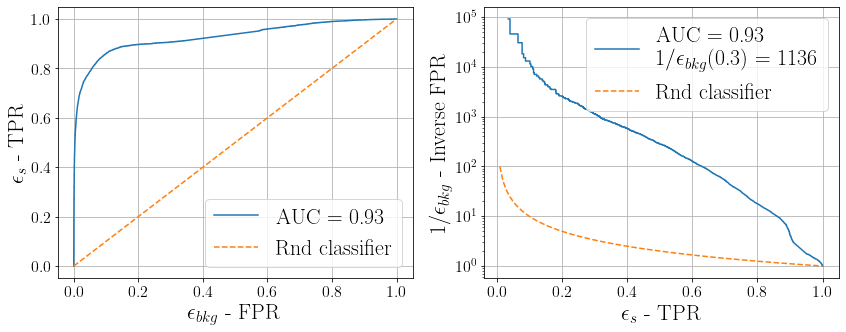

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve( y_test, test_pred_oc )
auc_score = roc_auc_score( y_test, test_pred_oc )
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

Now a comparison.

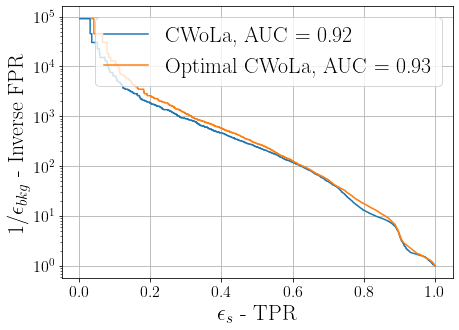

In [78]:
fig, ax = plt.subplots( figsize=(7,5))

fpr_sb10pc, tpr_sb10pc, th_sb10pc = roc_curve( y_test, test_pred )
fpr_oc, tpr_oc, th_oc = roc_curve( y_test, test_pred_oc )

auc_score_sb10pc = roc_auc_score( y_test, test_pred )
auc_score_oc = roc_auc_score( y_test, test_pred_oc )

rnd_class = np.linspace(0, 1, 100)

ax.plot(tpr_sb10pc, 1/fpr_sb10pc, label='CWoLa, AUC = {:.2f}'.format(auc_score_sb10pc))
ax.plot(tpr_oc, 1/fpr_oc, label='Optimal CWoLa, AUC = {:.2f}'.format(auc_score_oc))
#ax.plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax.set_yscale('log')

ax.set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax.set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
ax.legend(prop=axislabelfont)
ax.tick_params(labelsize=axisfontsize)
ax.grid('on')

## K-fold cross validation

In an experiment we want to use all of the data, but we also need to validate and test.  We can do this with cross-validation.

1. split data into $k$ clusters
2. use $k\!-\!1$ of the clusters to construct training and validation data
3. optimise the network and test on the $k^{\text{th}}$ cluster
4. repeat steps 2 and 3 $k$ times, iterating through the cluster used for testing
5. aggregate the results so that all of the data has been tested on